In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier, RidgeCV
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score,log_loss

import statsmodels.api as sm 
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

import warnings
warnings.filterwarnings('ignore')



In [2]:
'''import DataCleaning
from featureVisualization import FeatureVisualization

# Initialize the data cleaner
df_cleaner = DataCleaning.CleanDataFrame()

# Clean the data
train_df, test_df = df_cleaner.clean_data()

# Initialize the visualization class with the cleaned training data
viz = FeatureVisualization(train_df)

# Create the court visualization
viz.court_visualization()

viz.count
'''


'import DataCleaning\nfrom featureVisualization import FeatureVisualization\n\n# Initialize the data cleaner\ndf_cleaner = DataCleaning.CleanDataFrame()\n\n# Clean the data\ntrain_df, test_df = df_cleaner.clean_data()\n\n# Initialize the visualization class with the cleaned training data\nviz = FeatureVisualization(train_df)\n\n# Create the court visualization\nviz.court_visualization()\n\nviz.count\n'

In [3]:
df = pd.read_csv('data.csv', index_col = 'shot_id').drop(['game_event_id','team_id','team_name','game_id','action_type',],axis = 1)
test_df = pd.read_csv('sample_submission.csv')
df.head(10)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 1 to 30697
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   combined_shot_type  30697 non-null  object 
 1   lat                 30697 non-null  float64
 2   loc_x               30697 non-null  int64  
 3   loc_y               30697 non-null  int64  
 4   lon                 30697 non-null  float64
 5   minutes_remaining   30697 non-null  int64  
 6   period              30697 non-null  int64  
 7   playoffs            30697 non-null  int64  
 8   season              30697 non-null  object 
 9   seconds_remaining   30697 non-null  int64  
 10  shot_distance       30697 non-null  int64  
 11  shot_made_flag      25697 non-null  float64
 12  shot_type           30697 non-null  object 
 13  shot_zone_area      30697 non-null  object 
 14  shot_zone_basic     30697 non-null  object 
 15  shot_zone_range     30697 non-null  object 
 16  game

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


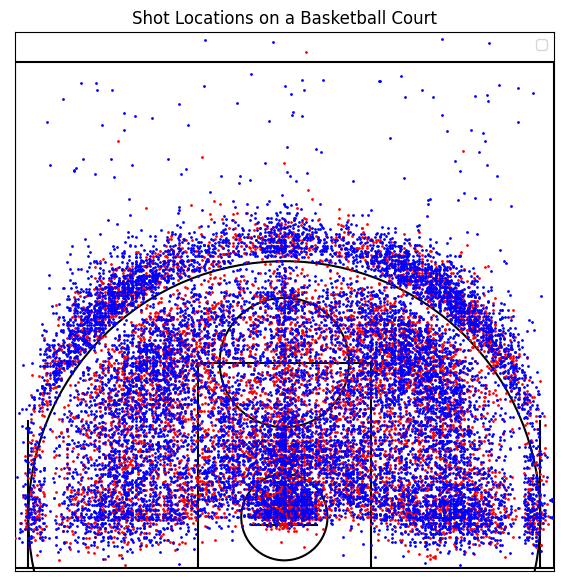

In [4]:
# Plotting the shot locations on a basketball court
fig, ax = plt.subplots(figsize=(15, 7))

# Drawing the basketball court
# Main court lines
plt.plot([-250, 250], [-47.5, -47.5], color='black')
plt.plot([-250, 250], [422.5, 422.5], color='black')
plt.plot([-250, -250], [-47.5, 422.5], color='black')
plt.plot([250, 250], [-47.5, 422.5], color='black')

# Hoops
hoop = plt.Circle((0, 0), 7.5, linewidth=1.5, color='black', fill=False)
ax.add_patch(hoop)

# Backboard
plt.plot([-30, 30], [-7.5, -7.5], color='black', linewidth=1.5)

# Paint area
plt.plot([-80, -80], [-47.5, 143.5], color='black')
plt.plot([80, 80], [-47.5, 143.5], color='black')
plt.plot([-80, 80], [143.5, 143.5], color='black')

# Free throw circle
free_throw_circle = plt.Circle((0, 143.5), 60, linewidth=1.5, color='black', fill=False)
ax.add_patch(free_throw_circle)

# Restricted area
restricted_area = plt.Circle((0, 0), 40, linewidth=1.5, color='black', fill=False)
ax.add_patch(restricted_area)

# Three point line
three_point_circle = plt.Circle((0, 0), 237.5, linewidth=1.5, color='black', fill=False)
ax.add_patch(three_point_circle)

# Three point line arcs
plt.plot([-237.5, -237.5], [-47.5, 89.477], color='black')
plt.plot([237.5, 237.5], [-47.5, 89.477], color='black')

# Drawing the shots
shot_made_in = df[df['shot_made_flag'] == 1]
shot_made_out = df[df['shot_made_flag'] == 0]

plt.scatter(shot_made_in['loc_x'], shot_made_in['loc_y'], color='red', s=1, zorder=10)
plt.scatter(shot_made_out['loc_x'], shot_made_out['loc_y'], color='blue', s=1, zorder=10)

plt.legend()
# Setting axis limits and removing ticks
plt.xlim(-250, 250)
plt.ylim(-50, 450)
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect('equal', adjustable='box')

plt.title('Shot Locations on a Basketball Court')
plt.show()

# Step 1: Cleaning Dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 1 to 30697
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   combined_shot_type  30697 non-null  object 
 1   lat                 30697 non-null  float64
 2   loc_x               30697 non-null  int64  
 3   loc_y               30697 non-null  int64  
 4   lon                 30697 non-null  float64
 5   minutes_remaining   30697 non-null  int64  
 6   period              30697 non-null  int64  
 7   playoffs            30697 non-null  int64  
 8   season              30697 non-null  object 
 9   seconds_remaining   30697 non-null  int64  
 10  shot_distance       30697 non-null  int64  
 11  shot_made_flag      25697 non-null  float64
 12  shot_type           30697 non-null  object 
 13  shot_zone_area      30697 non-null  object 
 14  shot_zone_basic     30697 non-null  object 
 15  shot_zone_range     30697 non-null  object 
 16  game

In [6]:
# Check for missing values and duplicates.
duplicates = df.duplicated()

if duplicates.empty:
    print("We have duplicates values.\n")
else:
    print("We don't have duplicates values.\n")
    
# Check for missing values.
if df.isna().any().any():
    print("We have missing values")
    print("We need to handle this missing values.")
else:
    print("We don't have missing values.")

We don't have duplicates values.

We have missing values
We need to handle this missing values.


### The missing values are in the shot made feature which is our target feature. So we need to create two dataset, one with the labels and one without the labels.

In [7]:
# Create the test data Frame
test_df = df[df['shot_made_flag'].isnull()]

# Drop the nan values from the dataset. For now this is the dataset we work.
train_df = df.dropna()

# Return the train df.
train_df.head()

,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,
2,Jump Shot,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR
3,Jump Shot,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
4,Jump Shot,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
5,Dunk,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR
6,Jump Shot,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR


Change the datatype of some columns

In [8]:
# Create a function that change the datatype of some features.

def data_type_change(df):
    # Change the game_date to datetime format
    df['game_date'] = pd.to_datetime(df['game_date'])

    # Chagne the period to categorical variable.
    df['period'] = df['period'].astype('object')

    # Change the playoff to categorical
    df['playoffs'] = df['playoffs'].astype('object')

    # Shot made flag to categorical
    df['shot_made_flag'] = df['shot_made_flag'].astype('object')


# Change the datatype of the train_df
data_type_change(train_df)  

# STEP 2: Explanatory Data Analyssis (EDA)

The first step in this section is to see the target feature.
We can see that the target feature is balanced. So we will not use balanced techniques like undresampling, oversampling or SMOTE.

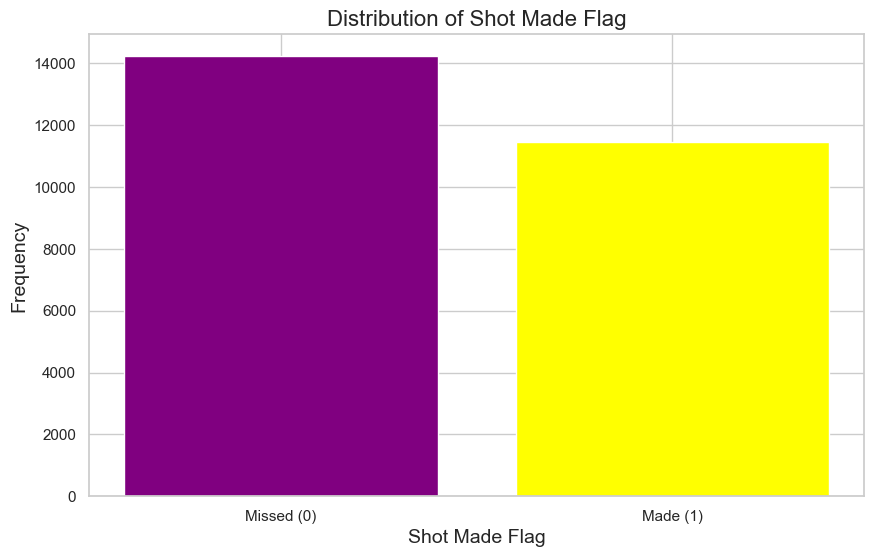

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the histogram with customized colors using manual plotting to ensure specific color assignment
plt.figure(figsize=(10, 6))

# Plotting each category separately to assign specific colors
shot_made_counts = train_df['shot_made_flag'].value_counts().sort_index()
plt.bar(shot_made_counts.index, shot_made_counts.values, color=['purple', 'yellow'])

# Adding titles and labels
plt.title('Distribution of Shot Made Flag', fontsize=16)
plt.xlabel('Shot Made Flag', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customizing the x-ticks
plt.xticks(ticks=[0, 1], labels=['Missed (0)', 'Made (1)'])

# Display the plot
plt.show()


Let's start exploring the numerical features of the dataset.

In [10]:
numerical_columns = train_df.select_dtypes(['int','float']).columns
print(numerical_columns)

Index(['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining',
       'seconds_remaining', 'shot_distance'],
      dtype='object')


Check the distribution of the numerical columns.

From the following results we can see that the shot might be effected by the shot distance and the minutes remaining.

Furthermore we will apply some feature engineering techniques, so we need to visualize further our hypothesis. Maybe we need to apply some statistical test to determine if we are correct.

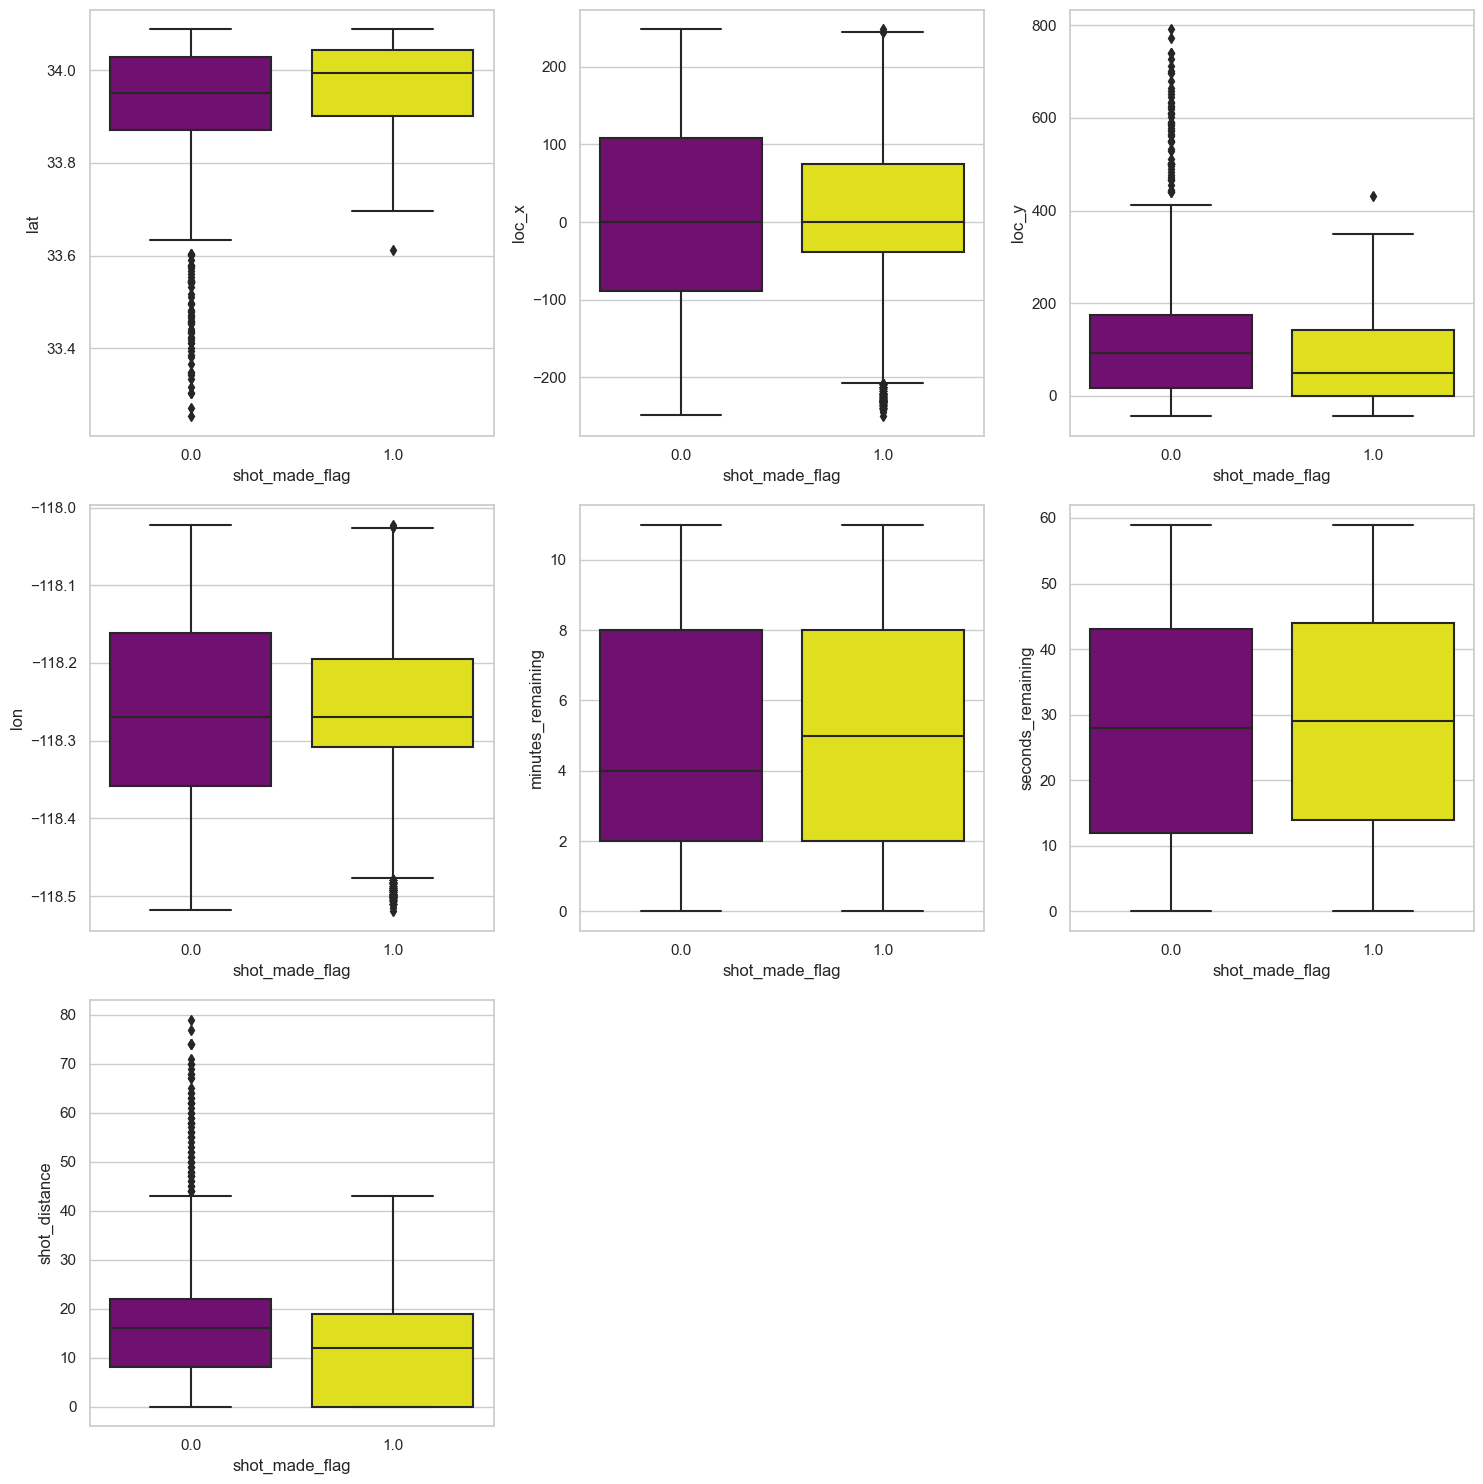

In [11]:
def num_plotter(data, target):
   # Select numeric columns
    numerical_columns = data.select_dtypes(['int','float']).columns

    # Number of plots
    n_plots = len(numerical_columns)

    # Calculate number of rows needed
    n_cols = 3
    n_rows = math.ceil(n_plots / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Plot each numeric column
    for ax, col in zip(axes, numerical_columns):
        sns.boxplot(data=data, x=target, y=col, ax=ax,palette=['purple', 'yellow'])

    # Remove empty subplots
    for ax in axes[n_plots:]:
        ax.remove()

    # Display the plots
    plt.tight_layout()
    plt.show()
        
num_plotter(train_df, "shot_made_flag")

Check the distribution of the numerical variable.s

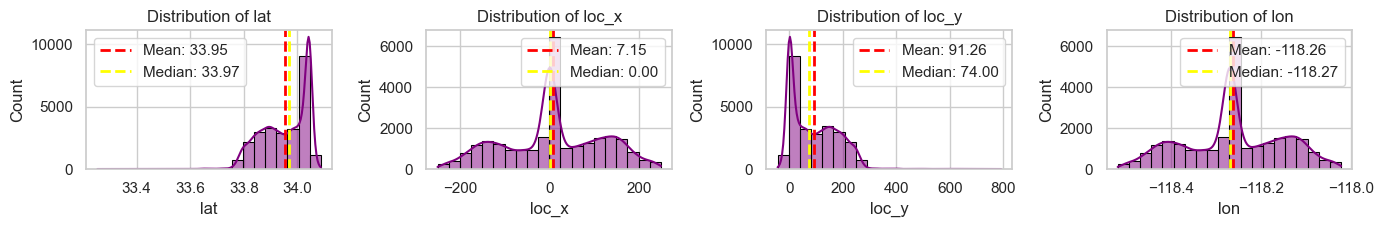

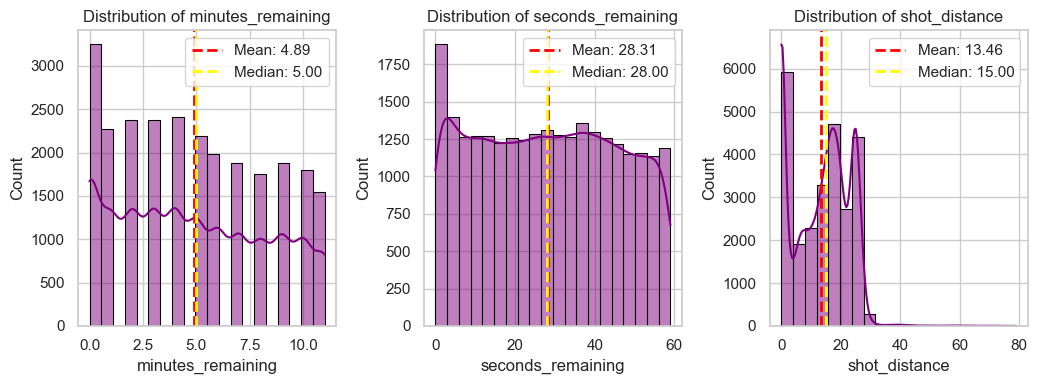

In [12]:
columns_per_figure = 4
num_numerical_columns = len(numerical_columns)


# Loop through numerical columns and plot distributions
for i in range(0, len(numerical_columns), columns_per_figure):
    columns_subset = numerical_columns[i:i+columns_per_figure]
    
    # Create a new figure
    plt.figure(figsize=(14, 4))
    
    for j, column in enumerate(columns_subset, start=1):
        plt.subplot((num_numerical_columns - i - 1) // columns_per_figure + 1, columns_per_figure, j)
        
        # Check the distribution of each numerical column
        sns.histplot(data=train_df, x=column, bins=20, color='purple', edgecolor='black', kde=True)
        
        # Calculate mean and median
        mean_value = train_df[column].mean()
        median_value = train_df[column].median()
        
        # Add mean and median lines
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        plt.axvline(median_value, color='yellow', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
        
        # Set title and labels
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the figure
    plt.show()

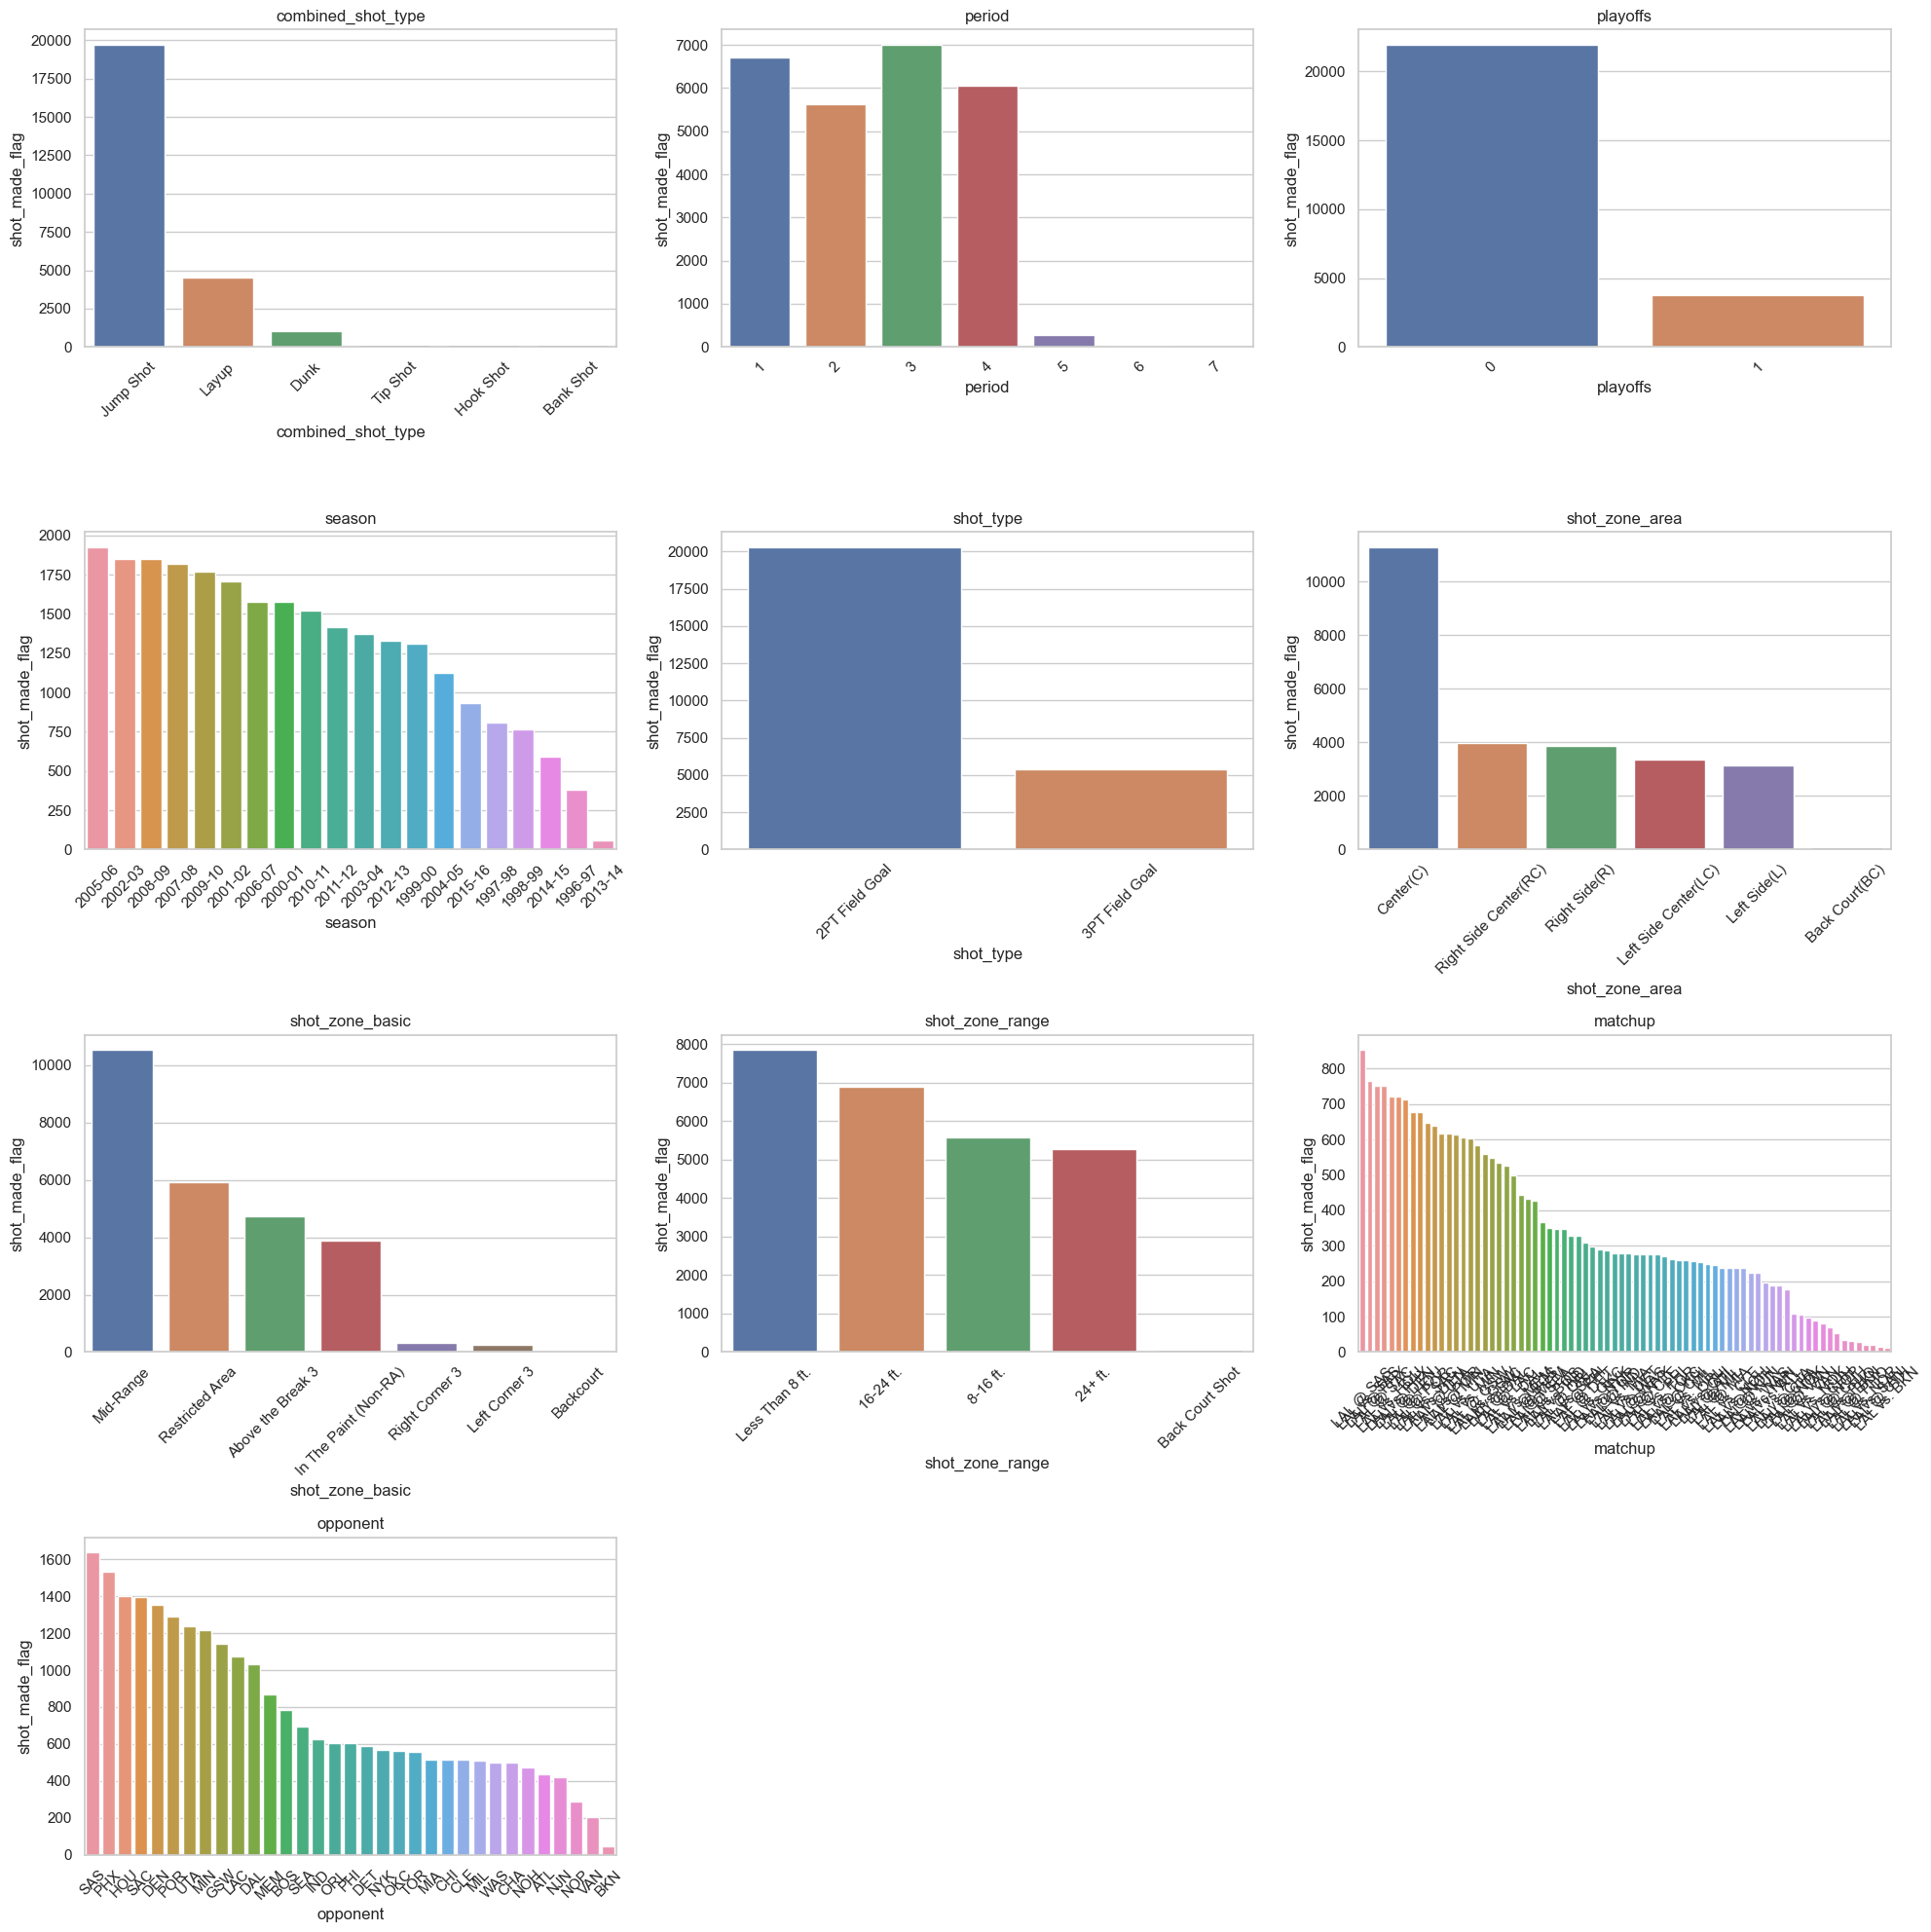

In [13]:
def cat_plotter(data, target,cat_columns):
    num_plots = len(cat_columns)
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(cat_columns):
        aggregated_data = (
            data
            .groupby(col, as_index=False)
            .agg({target: 'count'})
            .sort_values(by=target, ascending=False)
        )
        sns.barplot(
            data=aggregated_data,
            x=col,
            y=target,
            ax=axes[i]
        )
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(col)
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cat_columns = train_df.drop('shot_made_flag',axis =1 ).select_dtypes(['object']).columns.to_list()

# Call the function with your DataFrame and target column
cat_plotter(train_df, "shot_made_flag",cat_columns)

<AxesSubplot: >

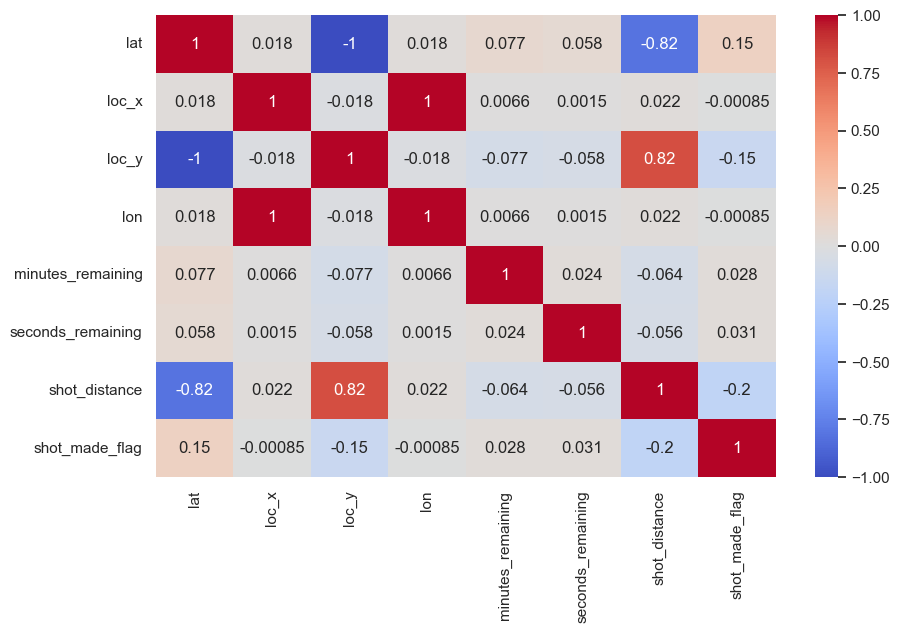

In [14]:
train_df['shot_made_flag'] = train_df['shot_made_flag'].astype('int')
plt.figure(figsize=(10, 6))

sns.heatmap(train_df.corr(),vmin = -1 , vmax =1, annot = True,cmap='coolwarm')

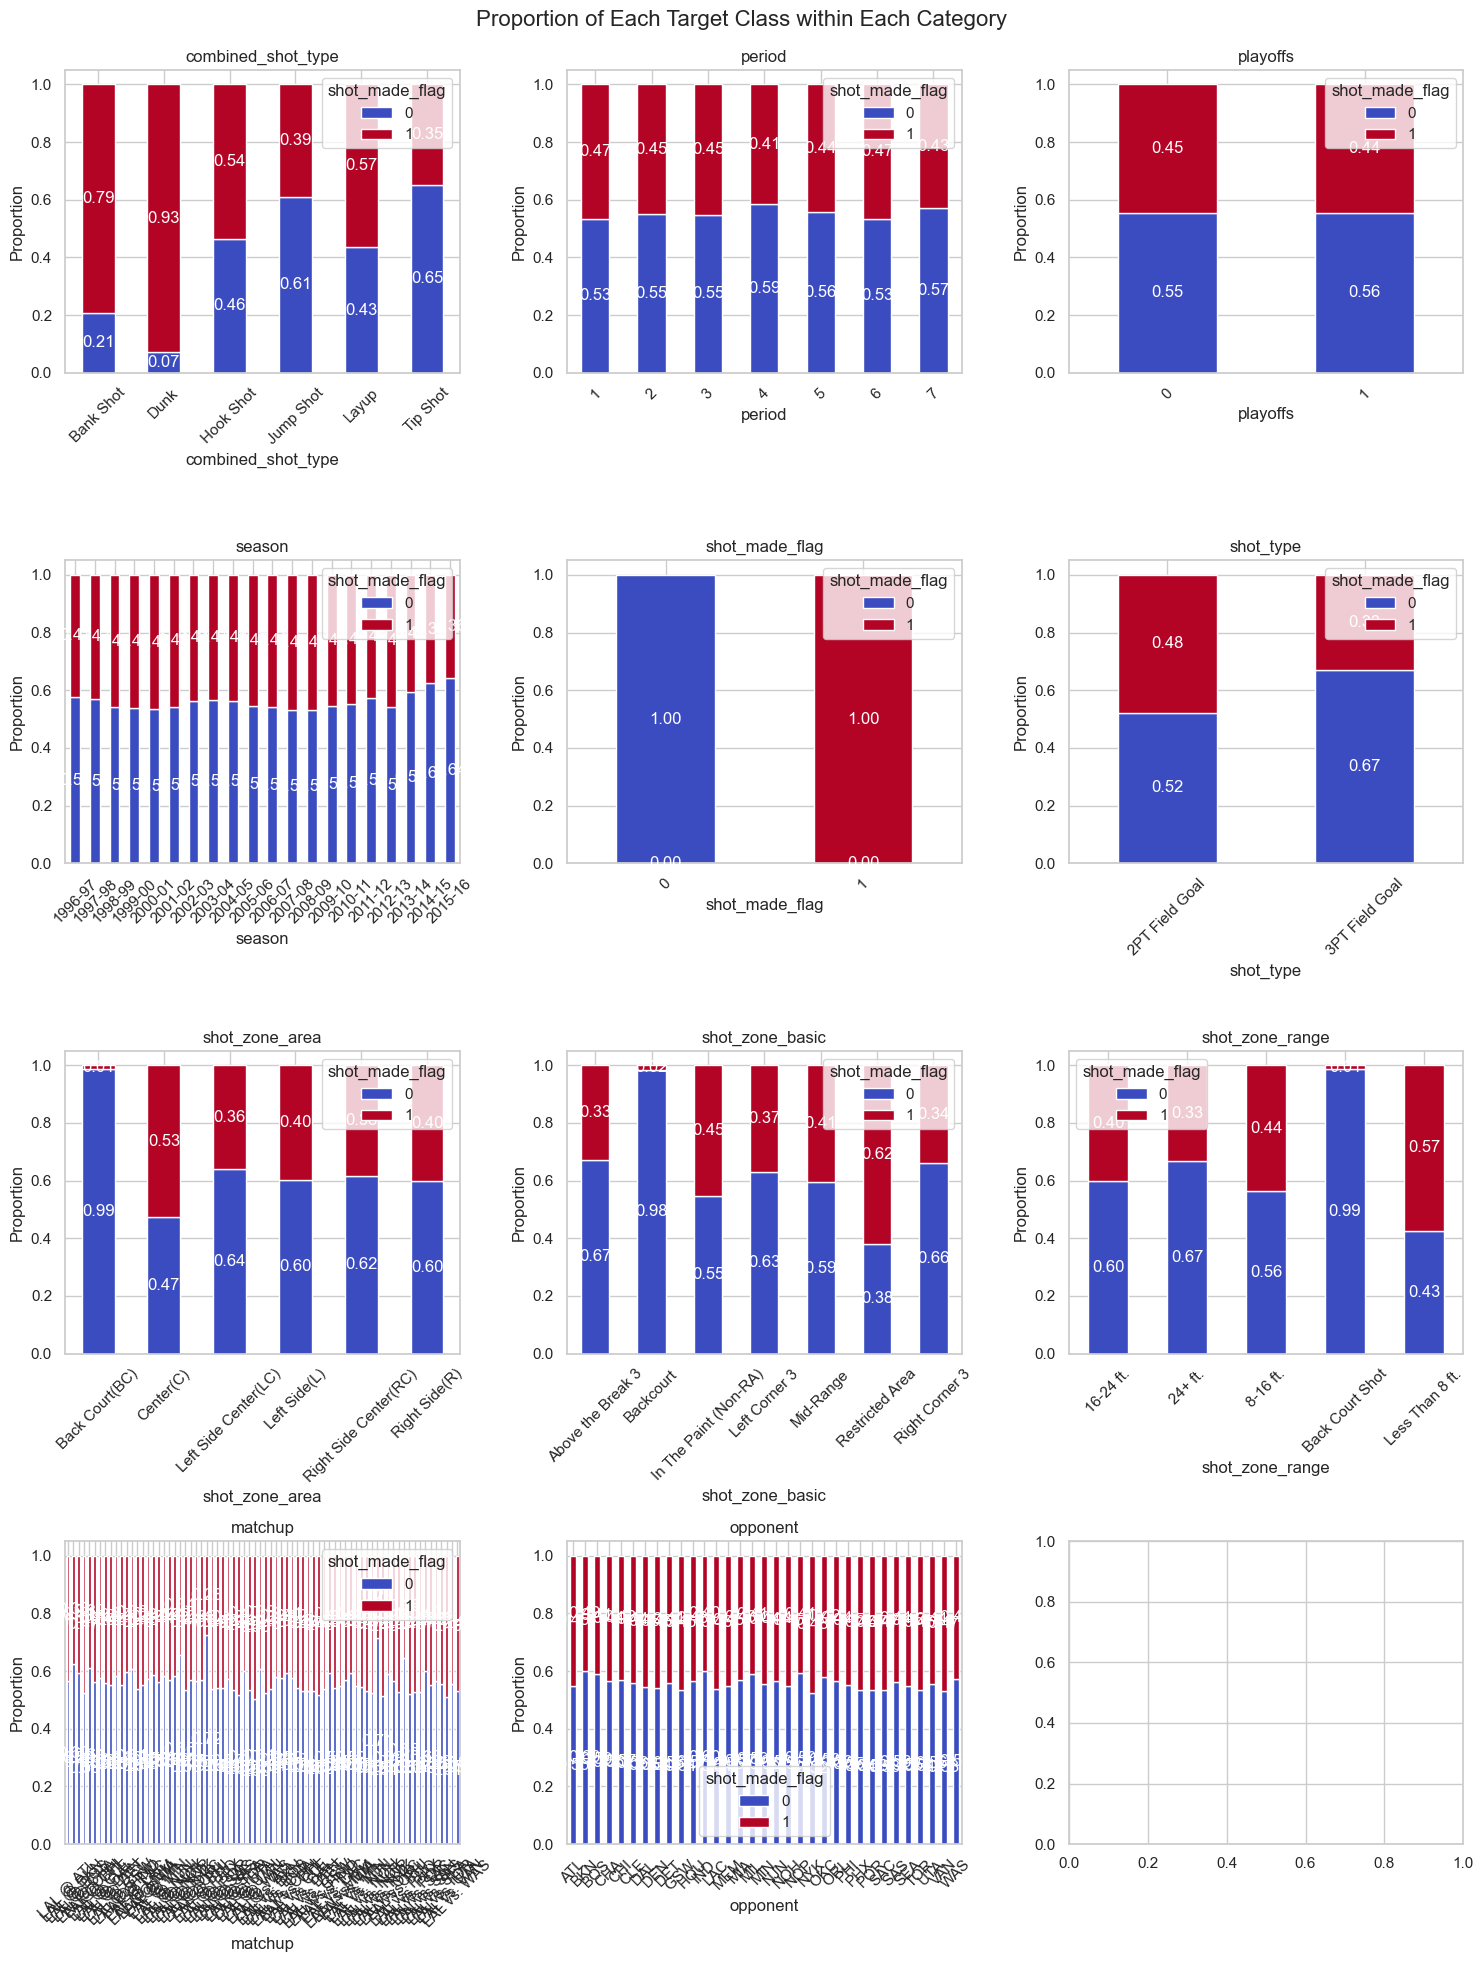

In [15]:
train_df['shot_made_flag'] = train_df['shot_made_flag'].astype('object')

def shot_percentage(train_df = train_df):
    # Identify categorical features
    categorical_features = train_df.select_dtypes(include=['object', 'category']).columns

    # Calculate number of rows and columns for subplots
    num_features = len(categorical_features)
    num_cols = 3  # Number of columns of subplots
    num_rows = (num_features + 1) // num_cols  # Number of rows of subplots, rounded up

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.suptitle('Proportion of Each Target Class within Each Category', fontsize=16)

    # Plot for each categorical feature
    for i, feature in enumerate(categorical_features):
        row = i // num_cols
        col = i % num_cols

        # Create a pivot table to get counts of target variable within each category of categorical feature
        pivot_table = pd.crosstab(train_df[feature], train_df['shot_made_flag'])

        # Normalize the counts to get proportions
        pivot_table_proportions = pivot_table.div(pivot_table.sum(axis=1), axis=0)

        # Plot the stacked bar plot
        ax = pivot_table_proportions.plot(kind='bar', stacked=True, colormap='coolwarm', ax=axes[row, col])

        # Add labels and title
        ax.set_xlabel(feature)
        ax.set_ylabel('Proportion')
        ax.set_title(f'{feature}')
        # Rotate x labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        # Add annotations
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center', color='white')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Add space for the title
    plt.show()

shot_percentage(train_df)  

# STEP 3: Feature Engineering.
Create new columns that we think we might be helpfull for predictions.


Ideas for feature engineering.

Group the teams based on division.

Να κάνουμε γκρουπ τις χρονολογίες του, ανά τετράδες

Πόσες ημέρες έχουν περάσει από τον πρώτο αγώνα της χρονιάς


In [16]:
# Create a new dataset and perform feature engineering in this DataFrame
final_df = train_df.copy()

In [17]:
# Create a column, that tells us how many second we have until the end of the period
final_df['secondsFromPeriodEnd']   = 60*final_df['minutes_remaining']+final_df['seconds_remaining']

# Create a column, that returns how many seconds has past from the start of a quarter.
final_df['secondsFromPeriodStart'] = 60*(11-final_df['minutes_remaining'])+(60-final_df['seconds_remaining'])

# Calculate the second until the end of the game.
final_df['secondsFromGameStart']   = ((final_df['period'] <= 4).astype(int)*(final_df['period']-1)*12*60 + 
                                        (final_df['period'] > 4).astype(int)*((final_df['period']-4)*5*60 + 3*12*60) 
                                          + final_df['secondsFromPeriodStart'])

#final_df.drop(['minutes_remaining', 'seconds_remaining'],axis = 1, inplace = True)

In [18]:
# Remove duplicate dates to calculate the difference in days
unique_dates = final_df['game_date'].drop_duplicates().reset_index(drop=True)
days_passed = unique_dates.diff().dt.days.fillna(0).astype(int)

# Create a DataFrame with the unique dates and their corresponding days_passed values
days_passed_df = pd.DataFrame({'game_date': unique_dates, 'days_passed': days_passed})

# Merge this DataFrame back to the original DataFrame to assign days_passed to each observation
final_df = final_df.merge(days_passed_df, on='game_date', how='left')

In [19]:

# Create a new variable based on the halftime.
final_df['Half_time'] = np.where(final_df['period'] < 2, 'First_half', 
                                np.where(final_df['period'] > 4, 'Over_Time', 'Second_half'))

# chagne the 5,6,7 period to Over-Time
final_df['period'] = np.where(final_df['period'] >= 5, 'Over-Time', final_df['period'])


In [20]:
# Create a new featrue. In basketball the home court is an advantage. 
# So we extract information from the matchup feature, to see if the game took place in the home or away court
# the @ tells as that the Kobe's team play as a visitors.
final_df['Court_Advantage'] = np.where(final_df['matchup'].str.contains('@'), 'No', 'Yes')

# After extracting the information of the home or away court, drop the matchup column.
final_df.drop(['matchup'], axis =1 , inplace = True)

Chekc Furthermore some featrues.

We can see that we have many features whick tells us about the diastance or area of the shot. So we think that some features might be overlief others. 

From the following we can see that we are correct. So we will keep only some of the features.


In [21]:
# Let's check furthermore some features.

# Create a new dataframe which include only the Left Corner 3 from Kobe
df2 = final_df[final_df['shot_zone_basic'] == 'Left Corner 3']

# Create a new datafame which include 3 points attempts and the the shot area is left side
df1 = final_df[(final_df['shot_type'] == '3PT Field Goal') & (final_df['shot_zone_area'] == 'Left Side(L)')]


print(f"Kobe shot from the Left Corner 3: {df2.shape[0]} times")
print(f"Kobe shot from 3 and the Left Side: {df1.shape[0]} times")

# Create a Union table 
union_df = pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)
print(f"The Union Table returns {union_df.shape[0]} observations")

# Also check this from the Right side.

df2 = final_df[final_df['shot_zone_basic'] == 'Right Corner 3']
df1 = final_df[(final_df['shot_type'] == '3PT Field Goal') & (final_df['shot_zone_area'] == 'Right Side(R)')]


print(f"Kobe shot from the Right Corner 3: {df2.shape[0]} times")


print(f"Kobe shot from 3 and the Right Side: {df1.shape[0]} times")

union_df = pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)

# We drop the shot type and the shot zone area. But we will and change this if it necessary.
#final_df.drop(['shot_type', 'shot_zone_area'], axis = 1, inplace = True)

Kobe shot from the Left Corner 3: 240 times
Kobe shot from 3 and the Left Side: 243 times
The Union Table returns 243 observations
Kobe shot from the Right Corner 3: 333 times
Kobe shot from 3 and the Right Side: 337 times


In [22]:
# Change the opponent featrue and create new columns.
Western_Eastern = {
    'Western_Conference': ['UTA', 'VAN',' LAC', 'SAS', 'DEN' 'GSW', 'MIN',' SEA','DAL', 'POR',
                          'PHX','MEM','NOP','NOH','OKC']
}
# Create a lookup dictionary for quick access
conference_lookup = {}
for team in Western_Eastern['Western_Conference']:
    conference_lookup[team.strip()] = 'Western_Conference'

# Function to get conference based on the opponent
def get_conference(opponent):
    opponent = opponent.strip()
    return conference_lookup.get(opponent, 'Eastern_Conference')

final_df['conference'] = final_df['opponent'].apply(get_conference)
final_df.conference.value_counts()

Eastern_Conference    13576
Western_Conference    12121
Name: conference, dtype: int64

The NBA teams are divided into 6 sub-groups which is named Divisions, based on the geographical criterion. 

In the area of Kobe Bryant the team with the best record in every division, has automatically an advantage in the first round of the playoffs. So Kobe might perform better versus this teams.

Let's group the teams based on the Division and then we will apply some statistical test to tetermine if there is significance in Kobe's Shooting performance.

In [23]:
Divisions = {
    'Atlantic': ['BOS', 'TOR', 'PHI', 'NJN', 'NYK','BKN'],
    'Central': ['MIL','CLE','IND','CHI','DET'],
    'SouthEast': ['ORL','MIA','WAS','ATL','CHA'],
    'NorthWest': ['OKC','DEN','MIN','POR','UTA','SEA'],
    'Pacific' :['LAC','PHX','SAC','GSW'],
    'SouthWest' : ['DAL','NOP','NOH','VAN','MEM','HOU','SAS']    
}


# Create a mapping from team to division
team_to_division = {}
for division, teams in Divisions.items():
    for team in teams:
        team_to_division[team] = division

# Map the 'opponent' column to the new 'division' column
final_df['division'] = final_df['opponent'].map(team_to_division)

In [24]:
seasons_group = {'1996-00': ['1996-97', '1997-98','1998-99', '1999-00'],
           '2000-04': ['2000-01', '2001-02', '2002-03', '2003-04'],
           '2004-08': ['2004-05', '2005-06', '2006-07', '2007-08'],
           '2008-12': ['2008-09', '2009-10', '2010-11', '2011-12'],
           '2012-16': ['2012-13', '2013-14', '2014-15', '2015-16']
}

# Create a mapping for the grouped seasons.
group_seasons = {}
for period, seasons in seasons_group.items():
    for season in seasons:
        group_seasons[season] = period
        
group_seasons
final_df['group_seasons'] = final_df['season'].map(group_seasons)

final_df['number'] = np.sqrt(np.absolute(final_df['lat'])*np.absolute(final_df['lon']))


In [25]:
# Drop the negative days , and the days which is over 300.
final_df = final_df[(final_df['days_passed']>0) ]#& (final_df['days_passed']<10)]

final_df[final_df['days_passed']>20]


,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,...,secondsFromPeriodEnd,secondsFromPeriodStart,secondsFromGameStart,days_passed,Half_time,Court_Advantage,conference,division,group_seasons,number
1274,Jump Shot,33.8753,-84,169,-118.3538,10,1,0,2001-02,34,...,634,86,86,196,First_half,Yes,Western_Conference,NorthWest,2000-04,63.318800
1275,Jump Shot,33.9153,85,129,-118.1848,10,1,0,2001-02,6,...,606,114,114,196,First_half,Yes,Western_Conference,NorthWest,2000-04,63.310923
1276,Dunk,34.0443,0,0,-118.2698,9,1,0,2001-02,42,...,582,138,138,196,First_half,Yes,Western_Conference,NorthWest,2000-04,63.454019
1277,Jump Shot,33.9093,37,135,-118.2328,7,1,0,2001-02,54,...,474,246,246,196,First_half,Yes,Western_Conference,NorthWest,2000-04,63.318177
1278,Jump Shot,34.0293,73,15,-118.1968,6,1,0,2001-02,21,...,381,339,339,196,First_half,Yes,Western_Conference,NorthWest,2000-04,63.420457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25386,Jump Shot,34.0393,164,5,-118.1058,1,3,1,1999-00,56,...,116,604,2044,336,Second_half,Yes,Eastern_Conference,Pacific,1996-00,63.405353
25387,Jump Shot,33.9163,85,128,-118.1848,4,4,1,1999-00,7,...,247,473,2633,336,Second_half,Yes,Eastern_Conference,Pacific,1996-00,63.311856
25388,Layup,34.0443,0,0,-118.2698,2,4,1,1999-00,8,...,128,592,2752,336,Second_half,Yes,Eastern_Conference,Pacific,1996-00,63.454019
25389,Tip Shot,34.0443,0,0,-118.2698,0,4,1,1999-00,38,...,38,682,2842,336,Second_half,Yes,Eastern_Conference,Pacific,1996-00,63.454019


In [26]:
final_df.shape

(25686, 28)

# Step 4: Visualize the new featrues and perform statistical tests.
At first let's visualize the new categorical data which is the Court Advantage. 

It seems that Kobe shot slightly better in the Home court so, the featrue might be good predictor. 

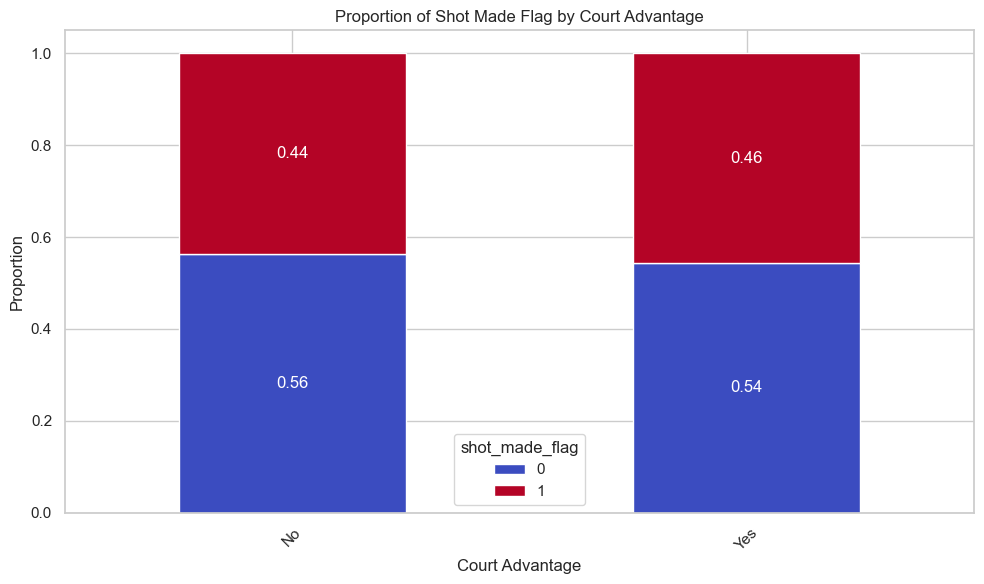

In [27]:
pivot_table = pd.crosstab(final_df['Court_Advantage'], final_df['shot_made_flag'])

# Normalize the counts to get proportions
pivot_table_proportions = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Plot the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_table_proportions.plot(kind='bar', stacked=True, colormap='coolwarm', ax=ax)

# Add labels and title
ax.set_xlabel('Court Advantage')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Shot Made Flag by Court Advantage')

# Rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center', color='white')

# Show plot
plt.tight_layout()
plt.show()

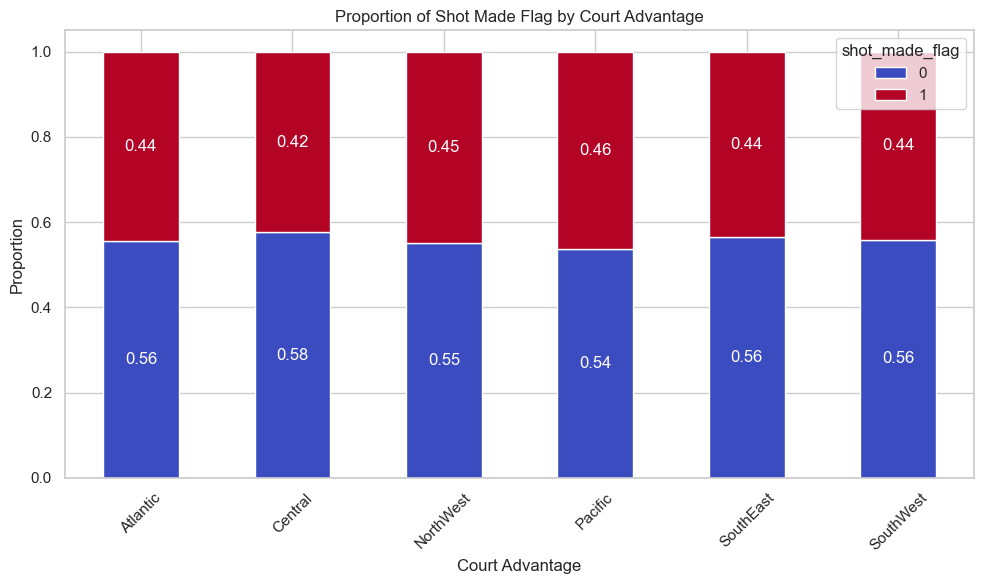

In [28]:
pivot_table = pd.crosstab(final_df['division'], final_df['shot_made_flag'])

# Normalize the counts to get proportions
pivot_table_proportions = pivot_table.div(pivot_table.sum(axis=1), axis=0)

# Plot the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))
pivot_table_proportions.plot(kind='bar', stacked=True, colormap='coolwarm', ax=ax)

# Add labels and title
ax.set_xlabel('Court Advantage')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Shot Made Flag by Court Advantage')

# Rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center', color='white')

# Show plot
plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='Court_Advantage', ylabel='shot_made_flag'>

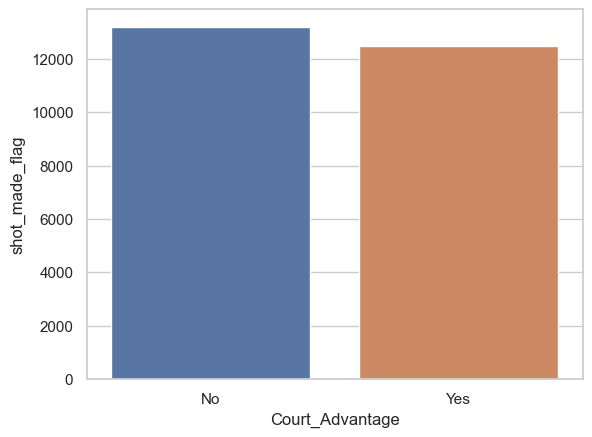

In [29]:
aggregated_data = (
            final_df
            .groupby('Court_Advantage', as_index=False)
            .agg({'shot_made_flag': 'count'})
            .sort_values(by='shot_made_flag', ascending=False)
        )
sns.barplot(
            data=aggregated_data,
            x='Court_Advantage',
            y='shot_made_flag',
        )

<AxesSubplot: xlabel='division', ylabel='shot_made_flag'>

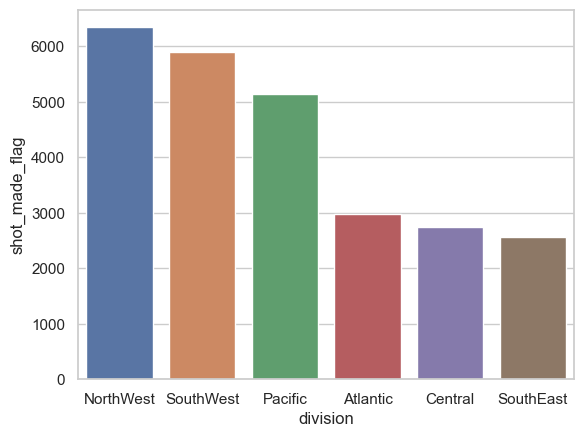

In [30]:
aggregated_data = (
            final_df
            .groupby('division', as_index=False)
            .agg({'shot_made_flag': 'count'})
            .sort_values(by='shot_made_flag', ascending=False)
        )
sns.barplot(
            data=aggregated_data,
            x='division',
            y='shot_made_flag',
        )

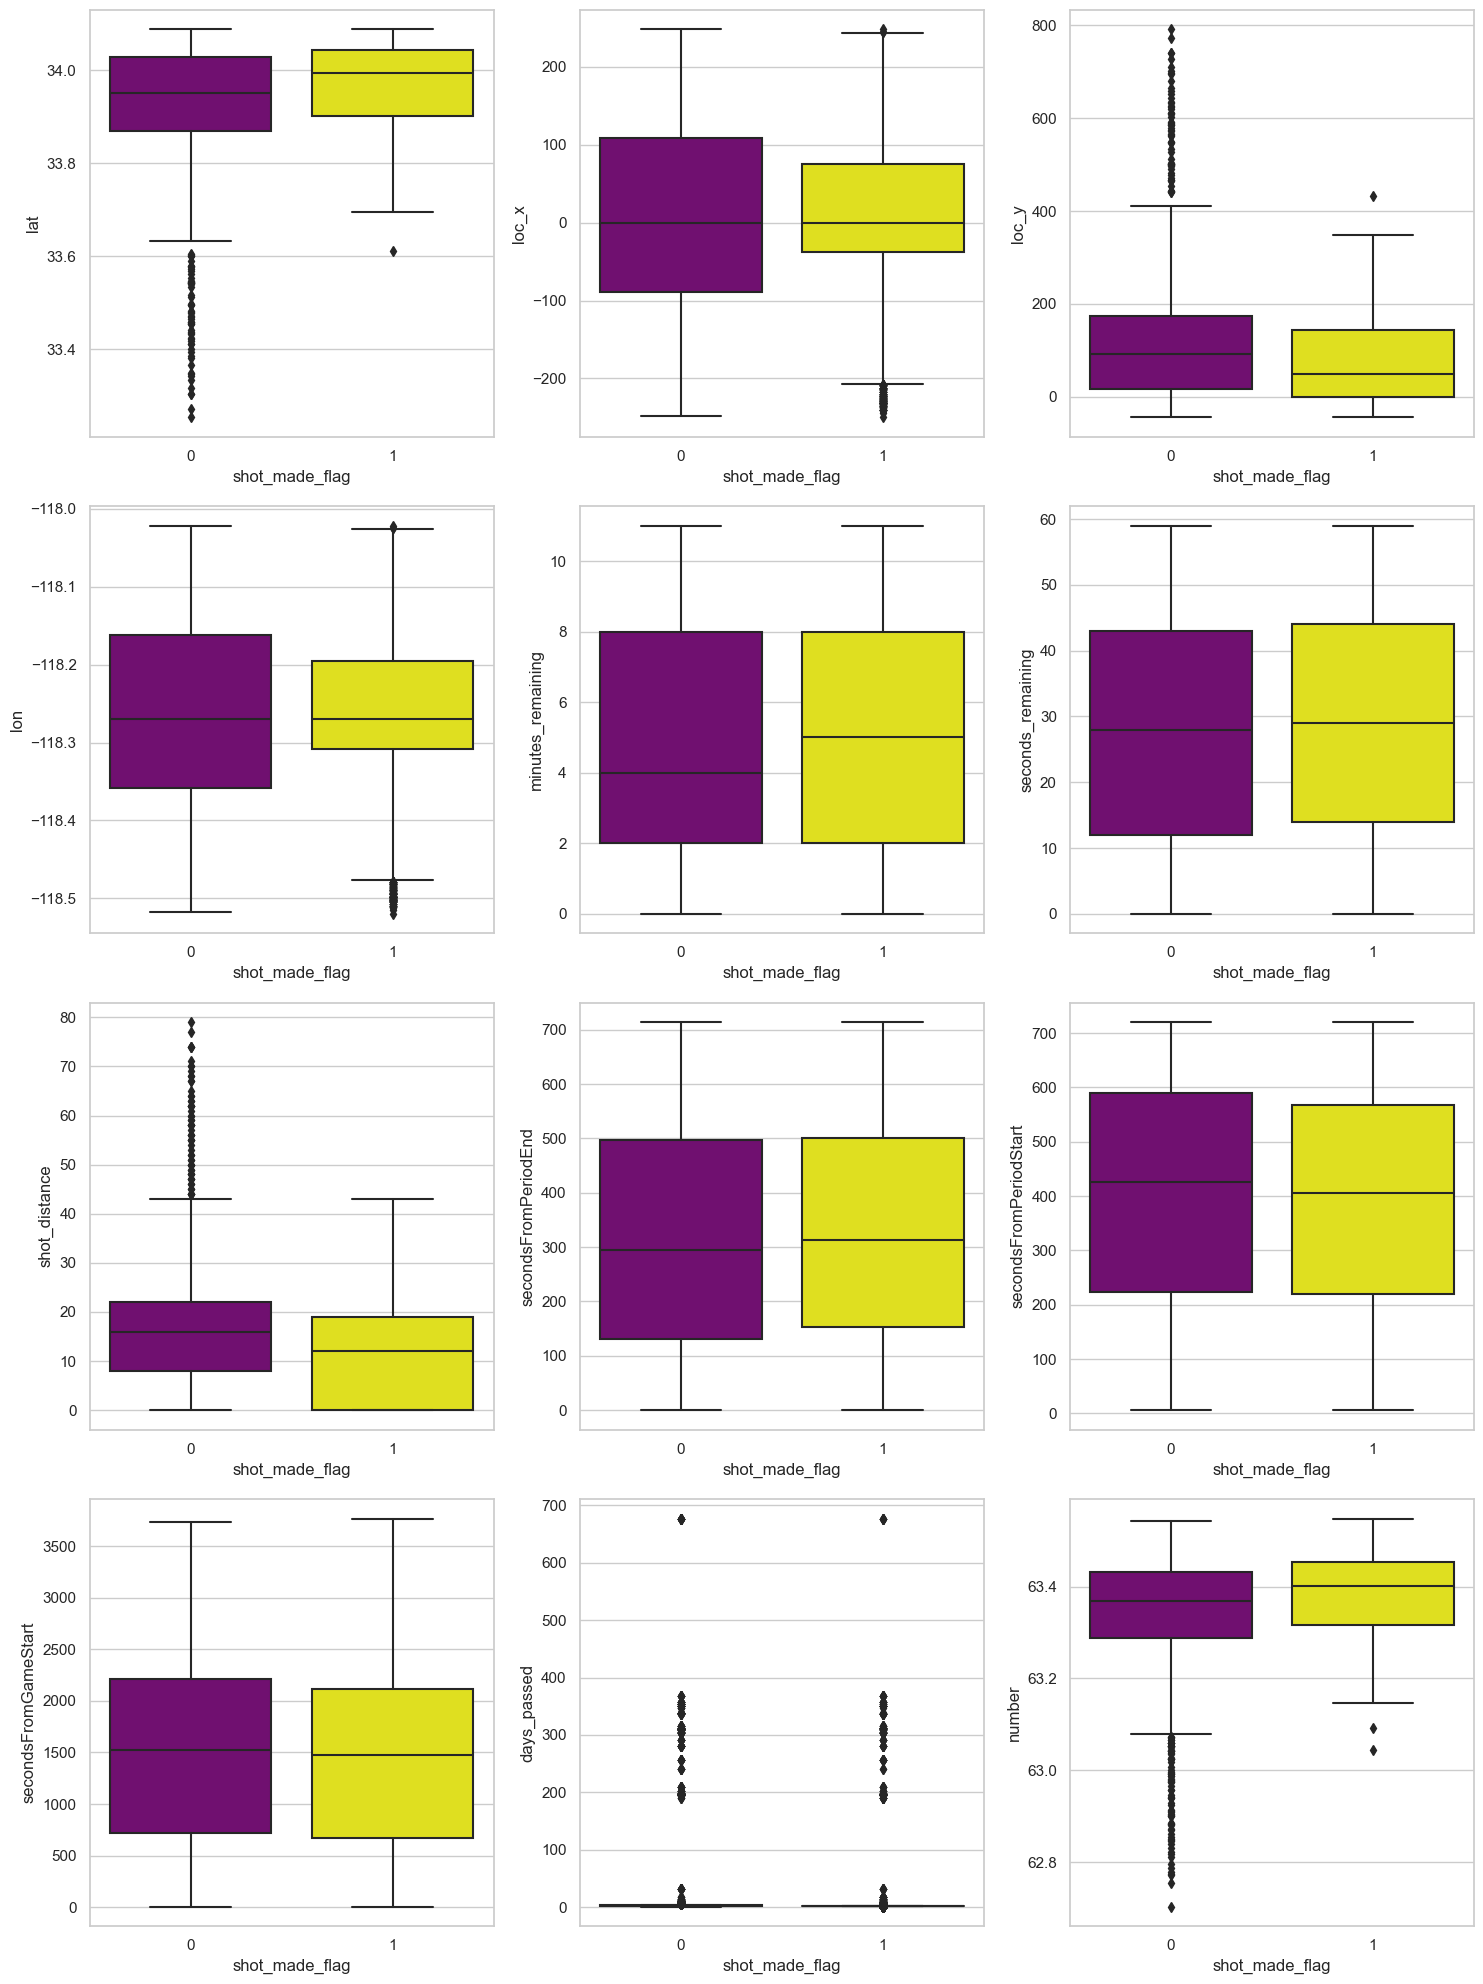

In [31]:
# Change the datatypes of the new numerical features.
final_df['secondsFromPeriodEnd'] = final_df['secondsFromPeriodEnd'].astype('int')
final_df['secondsFromPeriodStart'] = final_df['secondsFromPeriodStart'].astype('int')
final_df['secondsFromGameStart'] = final_df['secondsFromGameStart'].astype('int')


num_plotter(final_df, "shot_made_flag")


## Chi-square or Fisher test for categorical variable.
By applying this test to every categorical feature we will determine if variable is usefull  predictor for our model.

### Let's start by applying the test to the opponent feature.

In [32]:
# Statistical test to determine if some columns is usefull for predictions.

contingency_table = pd.crosstab(final_df['opponent'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 32.71860434670598
P-Value: 0.4315367673895986
Degrees of Freedom: 32


### Apply a fisher test to the playoffs feature.

In [33]:
# Statistical test to determine if some columns is usefull for predictions.
# Apply fisher test.
contingency_table = pd.crosstab(final_df['playoffs'], final_df['shot_made_flag'])
# Perform Fisher's Exact Test
oddsratio, p_value = fisher_exact(contingency_table)

print(f"Odds Ratio: {oddsratio}")
print(f"P-Value: {p_value}")

Odds Ratio: 0.992188620346882
P-Value: 0.8312437980317643


### Fisher test to the Court Advantage feature.


In [34]:
# Statistical test to determine if some columns is usefull for predictions.

contingency_table = pd.crosstab(final_df['Court_Advantage'], final_df['shot_made_flag'])

# Calculate the chi-squared value
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Chi-Squared: {chi2}")
print(f"P-Value: {p}")
print(f"Cramér's V: {cramers_v}")

Chi-Squared: 10.352417051642954
P-Value: 0.001293052654319405
Cramér's V: 0.02007578983562186


### Chi-Square test to the shot zone range.


In [35]:
contingency_table = pd.crosstab(final_df['shot_zone_range'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

# Calculate Cramér's V
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v}")
contingency_table

Chi-Square Statistic: 899.1819633798971
P-Value: 2.5055324621669054e-193
Degrees of Freedom: 4
Cramér's V: 0.1871007611665056


shot_made_flag,0,1
shot_zone_range,,
16-24 ft.,4130,2774
24+ ft.,3524,1756
8-16 ft.,3147,2428
Back Court Shot,71,1
Less Than 8 ft.,3354,4501


### Chi-square for the period feature.


In [36]:
contingency_table = pd.crosstab(final_df['period'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 38.03517187232549
P-Value: 1.1019935952739627e-07
Degrees of Freedom: 4


### Chi-square for the group season

In [37]:
contingency_table = pd.crosstab(final_df['group_seasons'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 20.606593224200587
P-Value: 0.00037891365830111255
Degrees of Freedom: 4


In [38]:
contingency_table = pd.crosstab(final_df['season'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 63.67657434226129
P-Value: 1.0001776541797908e-06
Degrees of Freedom: 19


In [39]:
contingency_table = pd.crosstab(final_df['conference'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 1.253943053297951
P-Value: 0.262800709618079
Degrees of Freedom: 1


In [40]:
contingency_table = pd.crosstab(final_df['shot_zone_basic'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 1102.706663915103
P-Value: 5.416213009026793e-235
Degrees of Freedom: 6


In [41]:
contingency_table = pd.crosstab(final_df['combined_shot_type'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 1559.6935195113408
P-Value: 0.0
Degrees of Freedom: 5


In [42]:
contingency_table = pd.crosstab(final_df['division'], final_df['shot_made_flag'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")


Chi-Square Statistic: 14.082216331338222
P-Value: 0.015095515574945048
Degrees of Freedom: 5


## Logistic Regression to the numerical variables.
By applying the logistic regression, we can determine which featrue is important for our model.

From the results, we can see that the loc_x and days_passed from the previous game might not be usefull predictors.

When we start modeling we will check if the models work better with this two features.

In [43]:
final_df['shot_made_flag'] = final_df['shot_made_flag'].astype(float)
final_df['loc_x'] = final_df['loc_x'].astype(float)
final_df['loc_y'] = final_df['loc_y'].astype(float)
final_df['lat'] = final_df['lat'].astype(float)
final_df['lon'] = final_df['lon'].astype(float)


X = final_df[[#'loc_x', 
              #'loc_y',
              'lat','lon',
              #'secondsFromPeriodStart',
              'days_passed',
              'secondsFromGameStart',
             'shot_distance', #'minutes_remaining',
              'seconds_remaining',
            #'number'
             ]]  # Selecting 'loc_x' and 'loc_y' as predictor variables

y = final_df['shot_made_flag']    # Selecting 'shot_made_flag' as the target variable

X = sm.add_constant(X)            # Adding a constant (intercept) to the predictor variables

log_reg = sm.Logit(y, X).fit()    # Fitting a logistic regression model

print(log_reg.summary())          # Printing the summary of the logistic regression model

print(log_reg.aic)

Optimization terminated successfully.
         Current function value: 0.666390
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         shot_made_flag   No. Observations:                25686
Model:                          Logit   Df Residuals:                    25679
Method:                           MLE   Df Model:                            6
Date:                Sun, 07 Jul 2024   Pseudo R-squ.:                 0.03048
Time:                        19:19:29   Log-Likelihood:                -17117.
converged:                       True   LL-Null:                       -17655.
Covariance Type:            nonrobust   LLR p-value:                3.005e-229
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   42.7345     17.069      2.504      0.012       9.280      76.189

# Step 5: Data Preparation and Logistic Regression Model



In [44]:
final_df['combined_shot_type'].value_counts()
final_df['Jump_Shot'] = np.where(final_df['combined_shot_type']=='Jump Shot',1,0)

In [45]:
columns_to_drop = ['shot_made_flag', 'game_date', 'conference', 'opponent',
                    'playoffs',
                   'secondsFromPeriodStart', 'secondsFromPeriodEnd' ,'minutes_remaining',
                  #combined_shot_type',
                   'shot_distance',
                   'season',
                   #'group_seasons',
                   'loc_x',
                   'loc_y',
                   #'number',
                   #'lat',
                   #'lon',
                   'days_passed',
                   #'Half_time',
                   'period'
                   ,'Jump_Shot',
                   'shot_type', 'shot_zone_area'
                  ]

# Ensure all categorical columns are strings
categorical_features = ['combined_shot_type', 
                        #'period',
                        'shot_zone_basic', 'shot_zone_range', 
                'division','Court_Advantage','group_seasons','Half_time',#'Jump_Shot'
               #shot_type', 'shot_zone_area'
                #'season',
]


# Dependent and Independent variables.
X = final_df.drop(columns_to_drop,axis =1 )
y = final_df['shot_made_flag']
X[categorical_features] = X[categorical_features].astype(str)

# Split the dataset into training and test set
X_tr, X_test, y_tr, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8)

# Split the training set into training and validation test.
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, random_state = 42, train_size = 0.75)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25686 entries, 9 to 25696
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   combined_shot_type    25686 non-null  object 
 1   lat                   25686 non-null  float64
 2   lon                   25686 non-null  float64
 3   seconds_remaining     25686 non-null  int64  
 4   shot_zone_basic       25686 non-null  object 
 5   shot_zone_range       25686 non-null  object 
 6   secondsFromGameStart  25686 non-null  int32  
 7   Half_time             25686 non-null  object 
 8   Court_Advantage       25686 non-null  object 
 9   division              25686 non-null  object 
 10  group_seasons         25686 non-null  object 
 11  number                25686 non-null  float64
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 2.4+ MB


In [46]:
# Define the preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # This will keep the remaining columns as they are
)

# Create a pipeline with the preprocessor and LogisticRegression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logistic_regression', LogisticRegression(max_iter=100))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Transform the validation data using the fitted pipeline's preprocessing step
# This step will only transform the data, without applying the final estimator
X_valid_transformed = pipeline.named_steps['preprocessor'].transform(X_valid)

# If you need to make predictions
predictions = pipeline.predict(X_valid)

print("The accuracy score of the Logistic Regression is:")
print(accuracy_score(predictions, y_valid))

probabilities = pipeline.predict_proba(X_valid)
loss = log_loss(y_valid, probabilities)
print(f"The log loss of the Logistic Regression model is: {loss:.4f}")


probabilities = pipeline.predict_proba(X_test)
loss = log_loss(y_test, probabilities)
print(f"The log loss of the Logistic Regression model is: {loss:.4f}")

The accuracy score of the Logistic Regression is:
0.6110570371812342
The log loss of the Logistic Regression model is: 0.6523
The log loss of the Logistic Regression model is: 0.6527


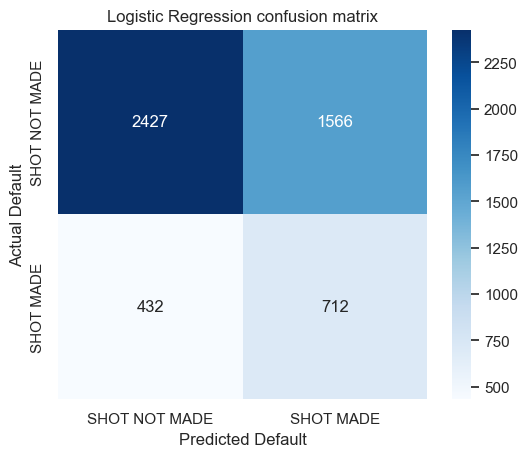

In [47]:
logistic_confusion= confusion_matrix(predictions, y_valid)

# Visualize the results by using a heeatmap. 
sns.heatmap(
    logistic_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"]
).set(
    xlabel='Predicted Default',
    ylabel='Actual Default',
    title='Logistic Regression confusion matrix'
);

### Apply cross validation

In [48]:
from sklearn.model_selection import cross_val_score, KFold

# Define the cross-validation method (5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Perform cross-validation
scores = cross_val_score(pipeline, X_tr, y_tr, cv=kf, scoring='accuracy')

# Print the cross-validation scores and mean score
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

Cross-validation scores: [0.60778589 0.6026764  0.60997567 0.60550012 0.61547822]
Mean cross-validation score: 0.6082832592866291


# Step 5: Regularized Logistic Regression

In [49]:
# At first we must redifined the training, validation and testing set.

# Create the testing sets.
X_tr, X_test, y_tr, y_test = train_test_split(X,y, random_state = 42, train_size = 0.8)

# Create the training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_tr,y_tr, random_state= 42, train_size = 0.75)

In [50]:
# Create a new Pipeline for the preprocessing
# Define the preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # This will keep the remaining columns as they are
)

# Create a pipeline with the preprocessor and StandardScaler.
# Regularized techniques required the data to be scaled.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Scaler', StandardScaler()),
    #('PCA_', PCA(n_components= 15))
])


# Fit the pipeline and scale the data.
X_train_std = pipeline.fit_transform(X_train)
X_valid_std = pipeline.transform(X_valid)
X_test_std = pipeline.transform(X_test)

In [51]:
'''# Create a dictionary for parameters that Regularized regression will use
parameters = {
    "C": np.linspace(.1, 2, 20),
    "penalty": ["l1", "l2"]
}

# Check all the hyperparameters of the model.
gridsearch = GridSearchCV(LogisticRegression(solver="saga"), parameters)

gridsearch.fit(X_train_std, y_train)
'''


'# Create a dictionary for parameters that Regularized regression will use\nparameters = {\n    "C": np.linspace(.1, 2, 20),\n    "penalty": ["l1", "l2"]\n}\n\n# Check all the hyperparameters of the model.\ngridsearch = GridSearchCV(LogisticRegression(solver="saga"), parameters)\n\ngridsearch.fit(X_train_std, y_train)\n'

In [52]:
#gridsearch.best_params_

NameError: name 'gridsearch' is not defined

In [54]:
#print(f"The best hyperparameters are: {gridsearch.best_params_}")

logreg = LogisticRegression(solver = 'saga', C = 0.1, penalty = 'l1') 

logreg.fit(X_train_std, y_train)


LogisticRegression(C=0.1, penalty='l1', solver='saga')

In [55]:
# Make prediction for validation and testing set.
valid_predictions = logreg.predict(X_valid_std)
test_predictions = logreg.predict(X_test_std)

# Calculate the Accuracy of the training set
print(f"Train Accuracy: {logreg.score(X_train_std, y_train)}\n")


# Calculate some metrics for the Validation Set
print("------- Calculate Metrics for Validation set.--------")
print(f"Validation Accuracy: {logreg.score(X_valid_std, y_valid)}")
print(f"The precision score for validation set is: {precision_score(y_valid,valid_predictions)}")
print(f"The recall score for validation set is: {recall_score(y_valid,valid_predictions)}")
print(f"The F1 score for validation set is: {f1_score(y_valid,valid_predictions)}")

# Calculate the log loss metric
# Calculate log loss for Validation Set (if applicable)
if hasattr(logreg, "predict_proba"):
    probabilities = logreg.predict_proba(X_valid_std)
    loss_valid = log_loss(y_valid, probabilities)
    print(f"Log Loss (Validation): {loss_valid:.4f}\n")

# Calculate some metrics for the testing set.
print("------- Calculate Metrics for Testing set.--------")
print(f"Validation Accuracy: {logreg.score(X_test_std, y_test)}")
print(f"The precision score for validation set is: {precision_score(y_test,test_predictions)}")
print(f"The recall score for validation set is: {recall_score(y_test,test_predictions)}")
print(f"The F1 score for validation set is: {f1_score(y_test,test_predictions)}")
if hasattr(logreg, "predict_proba"):
    probabilities = logreg.predict_proba(X_test_std)
    loss_valid = log_loss(y_test, probabilities)
    print(f"Log Loss (Validation): {loss_valid:.4f}\n")


Train Accuracy: 0.6135876970994744

------- Calculate Metrics for Validation set.--------
Validation Accuracy: 0.6145610278372591
The precision score for validation set is: 0.6302447552447552
The recall score for validation set is: 0.3165057067603161
The F1 score for validation set is: 0.4213909994155465
Log Loss (Validation): 0.6489

------- Calculate Metrics for Testing set.--------
Validation Accuracy: 0.6179447255741534
The precision score for validation set is: 0.6460251046025105
The recall score for validation set is: 0.33391003460207613
The F1 score for validation set is: 0.44026233247790136
Log Loss (Validation): 0.6496



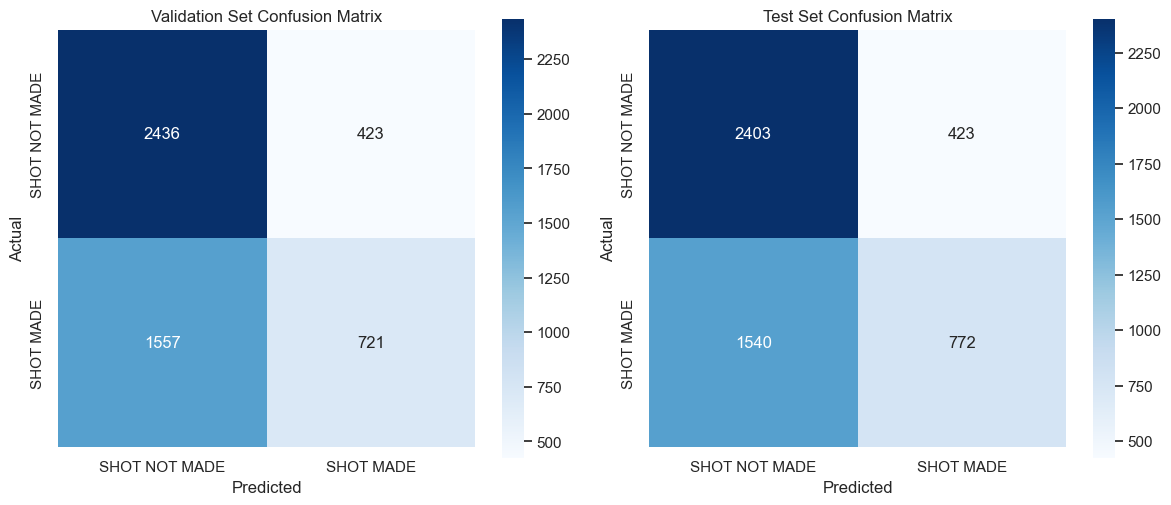

In [56]:
# Calculate confusion matrices
valid_confusion = confusion_matrix(y_valid, valid_predictions)
test_confusion = confusion_matrix(y_test, test_predictions)

# Set up the subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Valid set confusion matrix
sns.heatmap(
    valid_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"],
    ax=axes[0]
).set(
    xlabel='Predicted',
    ylabel='Actual',
    title='Validation Set Confusion Matrix'
)

# Test set confusion matrix
sns.heatmap(
    test_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"],
    ax=axes[1]
).set(
    xlabel='Predicted',
    ylabel='Actual',
    title='Test Set Confusion Matrix'
)

plt.tight_layout()
plt.show()

# Step 6 Decission Trees Classifier

In [57]:
# Define the preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # This will keep the remaining columns as they are
)

pipeline = Pipeline([
    ('transformer', preprocessor),
    ('PCA_', PCA(n_components= 15))
])
# Apply transformation to the Independent Variables.
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_valid_transformed = preprocessor.transform(X_valid)

In [58]:
# Building Decision Trees
dt = DecisionTreeClassifier()
dt.fit(X_train_transformed, y_train)

# Make prediction for validation and testing set
valid_predictions = dt.predict(X_valid_transformed)
test_predictions = dt.predict(X_test_transformed)

# Calculate the Accuracy of the training set
print(f"Train Accuracy: {dt.score(X_train_transformed, y_train)}\n")

# Calculate some metrics for the Validation Set
print("------- Calculate Metrics for Validation set.--------")
print(f"Validation Accuracy: {dt.score(X_valid_transformed, y_valid)}")
print(f"The precision score for validation set is: {precision_score(y_valid, valid_predictions)}")
print(f"The recall score for validation set is: {recall_score(y_valid, valid_predictions)}")
print(f"The F1 score for validation set is: {f1_score(y_valid, valid_predictions)}\n")
if hasattr(dt, "predict_proba"):
    probabilities_valid = dt.predict_proba(X_valid_transformed)
    loss_valid = log_loss(y_valid, probabilities_valid)
    print(f"Log Loss (Validation): {loss_valid:.4f}\n")

# Calculate some metrics for the testing set
print("------- Calculate Metrics for Testing set.--------")
print(f"Test Accuracy: {dt.score(X_test_transformed, y_test)}")
print(f"The precision score for testing set is: {precision_score(y_test, test_predictions)}")
print(f"The recall score for testing set is: {recall_score(y_test, test_predictions)}")
print(f"The F1 score for testing set is: {f1_score(y_test, test_predictions)}\n")
if hasattr(dt, "predict_proba"):
    probabilities_test = dt.predict_proba(X_test_transformed)
    loss_test = log_loss(y_test, probabilities_test)
    print(f"Log Loss (Test): {loss_test:.4f}\n")

Train Accuracy: 0.9992862241256245

------- Calculate Metrics for Validation set.--------
Validation Accuracy: 0.5579131788981896
The precision score for validation set is: 0.5015224010439322
The recall score for validation set is: 0.5061457418788411
The F1 score for validation set is: 0.5038234651518462

Log Loss (Validation): 15.9277

------- Calculate Metrics for Testing set.--------
Test Accuracy: 0.5381471389645777
The precision score for testing set is: 0.48697137975224264
The recall score for testing set is: 0.4930795847750865
The F1 score for testing set is: 0.49000644745325594

Log Loss (Test): 16.6059



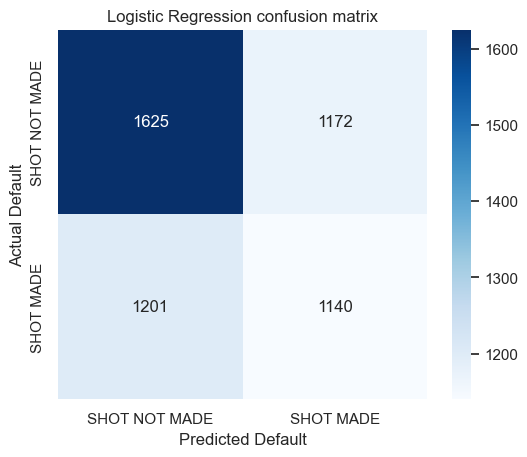

In [59]:
trees_confusion= confusion_matrix(test_predictions, y_test)

# Visualize the results by using a heeatmap. 
sns.heatmap(
    trees_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"]
).set(
    xlabel='Predicted Default',
    ylabel='Actual Default',
    title='Logistic Regression confusion matrix'
);

In [60]:
'''params = {
    "max_depth": [4, 6,8, ],
    "min_samples_leaf": [150,190,],
    "criterion": ["gini"]
}

grid = GridSearchCV(DecisionTreeClassifier(), params)

grid.fit(X_train_transformed, y_train)

grid.best_params_'''

'params = {\n    "max_depth": [4, 6,8, ],\n    "min_samples_leaf": [150,190,],\n    "criterion": ["gini"]\n}\n\ngrid = GridSearchCV(DecisionTreeClassifier(), params)\n\ngrid.fit(X_train_transformed, y_train)\n\ngrid.best_params_'

In [61]:
'''dt = DecisionTreeClassifier(**grid.best_params_)

dt.fit(X_train_transformed, y_train)

dt.score(X_train_transformed, y_train)'''


'dt = DecisionTreeClassifier(**grid.best_params_)\n\ndt.fit(X_train_transformed, y_train)\n\ndt.score(X_train_transformed, y_train)'

In [62]:
'''# Make prediction for validation and testing set
valid_predictions = dt.predict(X_valid_transformed)
test_predictions = dt.predict(X_test_transformed)

# Calculate the Accuracy of the training set
print(f"Train Accuracy: {dt.score(X_train_transformed, y_train)}\n")

# Calculate some metrics for the Validation Set
print("------- Calculate Metrics for Validation set.--------")
print(f"Validation Accuracy: {dt.score(X_valid_transformed, y_valid)}")
print(f"The precision score for validation set is: {precision_score(y_valid, valid_predictions)}")
print(f"The recall score for validation set is: {recall_score(y_valid, valid_predictions)}")
print(f"The F1 score for validation set is: {f1_score(y_valid, valid_predictions)}\n")
if hasattr(dt, "predict_proba"):
    probabilities_valid = dt.predict_proba(X_valid_transformed)
    loss_valid = log_loss(y_valid, probabilities_valid)
    print(f"Log Loss (Validation): {loss_valid:.4f}\n")

# Calculate some metrics for the testing set
print("------- Calculate Metrics for Testing set.--------")
print(f"Test Accuracy: {dt.score(X_test_transformed, y_test)}")
print(f"The precision score for testing set is: {precision_score(y_test, test_predictions)}")
print(f"The recall score for testing set is: {recall_score(y_test, test_predictions)}")
print(f"The F1 score for testing set is: {f1_score(y_test, test_predictions)}\n")
if hasattr(dt, "predict_proba"):
    probabilities_test = dt.predict_proba(X_test_transformed)
    loss_test = log_loss(y_test, probabilities_test)
    print(f"Log Loss (Test): {loss_test:.4f}\n")'''

'# Make prediction for validation and testing set\nvalid_predictions = dt.predict(X_valid_transformed)\ntest_predictions = dt.predict(X_test_transformed)\n\n# Calculate the Accuracy of the training set\nprint(f"Train Accuracy: {dt.score(X_train_transformed, y_train)}\n")\n\n# Calculate some metrics for the Validation Set\nprint("------- Calculate Metrics for Validation set.--------")\nprint(f"Validation Accuracy: {dt.score(X_valid_transformed, y_valid)}")\nprint(f"The precision score for validation set is: {precision_score(y_valid, valid_predictions)}")\nprint(f"The recall score for validation set is: {recall_score(y_valid, valid_predictions)}")\nprint(f"The F1 score for validation set is: {f1_score(y_valid, valid_predictions)}\n")\nif hasattr(dt, "predict_proba"):\n    probabilities_valid = dt.predict_proba(X_valid_transformed)\n    loss_valid = log_loss(y_valid, probabilities_valid)\n    print(f"Log Loss (Validation): {loss_valid:.4f}\n")\n\n# Calculate some metrics for the testing s

In [63]:
'''predictions1 = dt.predict(X_valid_transformed)
predictions = dt.predict(X_test_transformed)

trees_confusion= confusion_matrix(predictions, y_test)

# Visualize the results by using a heeatmap. 
sns.heatmap(
    trees_confusion, 
    cmap="Purples",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"]
).set(
    xlabel='Predicted Default',
    ylabel='Actual Default',
    title='Decision Trees confusion matrix'
);'''

'predictions1 = dt.predict(X_valid_transformed)\npredictions = dt.predict(X_test_transformed)\n\ntrees_confusion= confusion_matrix(predictions, y_test)\n\n# Visualize the results by using a heeatmap. \nsns.heatmap(\n    trees_confusion, \n    cmap="Purples",  \n    annot=True, \n    fmt="g",\n    square=True,\n    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        \n    yticklabels=["SHOT NOT MADE", "SHOT MADE"]\n).set(\n    xlabel=\'Predicted Default\',\n    ylabel=\'Actual Default\',\n    title=\'Decision Trees confusion matrix\'\n);'

In [64]:
'''probabilities = dt.predict_proba(X_valid_transformed)
loss = log_loss(y_valid, probabilities)
print(f"The log loss of the Logistic Regression model is: {loss:.4f}")


probabilities = dt.predict_proba(X_test_transformed)
loss = log_loss(y_test, probabilities)
print(f"The log loss of the Logistic Regression model is: {loss:.4f}")
if hasattr(logreg, "predict_proba"):
    probabilities = dt.predict_proba(X_valid_transformed)
    loss_valid = log_loss(y_valid, probabilities)
    print(f"Log Loss (Validation): {loss_valid:.4f}\n")
'''

'probabilities = dt.predict_proba(X_valid_transformed)\nloss = log_loss(y_valid, probabilities)\nprint(f"The log loss of the Logistic Regression model is: {loss:.4f}")\n\n\nprobabilities = dt.predict_proba(X_test_transformed)\nloss = log_loss(y_test, probabilities)\nprint(f"The log loss of the Logistic Regression model is: {loss:.4f}")\nif hasattr(logreg, "predict_proba"):\n    probabilities = dt.predict_proba(X_valid_transformed)\n    loss_valid = log_loss(y_valid, probabilities)\n    print(f"Log Loss (Validation): {loss_valid:.4f}\n")\n'

In [65]:
'''# Sort features by importance
sorted_idx = np.argsort(dt.feature_importances_)[::-1]
sorted_importances = dt.feature_importances_[sorted_idx]
sorted_features = np.array(preprocessor.get_feature_names_out())[sorted_idx]

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Decision Tree')
plt.tight_layout()
plt.show()'''

"# Sort features by importance\nsorted_idx = np.argsort(dt.feature_importances_)[::-1]\nsorted_importances = dt.feature_importances_[sorted_idx]\nsorted_features = np.array(preprocessor.get_feature_names_out())[sorted_idx]\n\n# Plot\nplt.figure(figsize=(10, 8))\nsns.barplot(x=sorted_importances, y=sorted_features)\nplt.xlabel('Feature Importance')\nplt.ylabel('Features')\nplt.title('Feature Importances from Decision Tree')\nplt.tight_layout()\nplt.show()"

In [66]:
'''import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(dt)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Visualize
shap.summary_plot(shap_values, X_train_transformed, feature_names=preprocessor.get_feature_names_out())
'''

'import shap\n\n# Initialize the SHAP explainer\nexplainer = shap.TreeExplainer(dt)\n\n# Calculate SHAP values\nshap_values = explainer.shap_values(X_train_transformed)\n\n# Visualize\nshap.summary_plot(shap_values, X_train_transformed, feature_names=preprocessor.get_feature_names_out())\n'

# Step 7: Random Forest Classifier

In [67]:
from sklearn.ensemble import RandomForestClassifier

# Building Decision Trees.
rf_untuned = RandomForestClassifier(random_state=2023, n_jobs=-1)


rf_untuned.fit(X_train_transformed, y_train)


# Make prediction for validation and testing set.
valid_predictions = rf_untuned.predict(X_valid_transformed)
test_predictions = rf_untuned.predict(X_test_transformed)

# Calculate the Accuracy of the training set
print(f"Train Accuracy: {rf_untuned.score(X_train_transformed, y_train)}\n")


# Calculate some metrics for the Validation Set
print("------- Calculate Metrics for Validation set.--------")
print(f"Validation Accuracy: {logreg.score(X_valid_std, y_valid)}")
print(f"The precision score for validation set is: {precision_score(y_valid,valid_predictions)}")
print(f"The recall score for validation set is: {recall_score(y_valid,valid_predictions)}")
print(f"The F1 score for validation set is: {f1_score(y_valid,valid_predictions)}\n")
if hasattr(dt, "predict_proba"):
    probabilities_valid = rf_untuned.predict_proba(X_valid_transformed)
    loss_valid = log_loss(y_valid, probabilities_valid)
    print(f"Log Loss (Validation): {loss_valid:.4f}\n")
    
# Calculate some metrics for the testing set.
print("------- Calculate Metrics for Testing set.--------")
print(f"Test Accuracy: {logreg.score(X_test_std, y_test)}")
print(f"The precision score for Test set is: {precision_score(y_test,test_predictions)}")
print(f"The recall score for Test set is: {recall_score(y_test,test_predictions)}")
print(f"The F1 score for Test set is: {f1_score(y_test,test_predictions)}\n")

Train Accuracy: 0.9992862241256245

------- Calculate Metrics for Validation set.--------
Validation Accuracy: 0.6145610278372591
The precision score for validation set is: 0.5379825653798257
The recall score for validation set is: 0.37928007023705007
The F1 score for validation set is: 0.44490216271884653

Log Loss (Validation): 0.6869

------- Calculate Metrics for Testing set.--------
Test Accuracy: 0.6179447255741534
The precision score for Test set is: 0.5560398505603985
The recall score for Test set is: 0.38624567474048443
The F1 score for Test set is: 0.4558448187850945



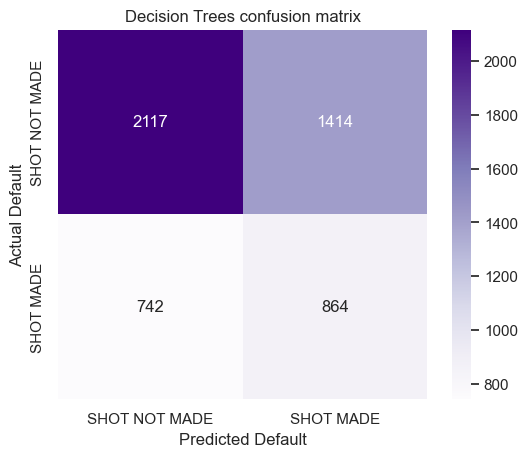

In [68]:
predictions1 = rf_untuned.predict(X_valid_transformed)
predictions = rf_untuned.predict(X_test_transformed)

trees_confusion= confusion_matrix(predictions1, y_valid)

# Visualize the results by using a heeatmap. 
sns.heatmap(
    trees_confusion, 
    cmap="Purples",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"]
).set(
    xlabel='Predicted Default',
    ylabel='Actual Default',
    title='Decision Trees confusion matrix'
);

In [69]:
'''from sklearn.model_selection import RandomizedSearchCV
      
rf = RandomForestClassifier(random_state=2023, n_jobs=-1)

params = {
    'n_estimators': np.arange(start=100, stop=1100, step=100),
    'max_features': [None, "sqrt"],
    'bootstrap': [True, False],
    'max_samples': [None, .3, .5, .9],
    'max_depth': np.arange(start=1, stop=11, step=1),
    'min_samples_leaf': [2, 5, 10, 20, 100],
}

grid = RandomizedSearchCV(
    rf, 
    params,
    n_iter=100,
    scoring="accuracy"
)

grid.fit(X_train_transformed, y_train)

grid.best_params_'''

'from sklearn.model_selection import RandomizedSearchCV\n      \nrf = RandomForestClassifier(random_state=2023, n_jobs=-1)\n\nparams = {\n    \'n_estimators\': np.arange(start=100, stop=1100, step=100),\n    \'max_features\': [None, "sqrt"],\n    \'bootstrap\': [True, False],\n    \'max_samples\': [None, .3, .5, .9],\n    \'max_depth\': np.arange(start=1, stop=11, step=1),\n    \'min_samples_leaf\': [2, 5, 10, 20, 100],\n}\n\ngrid = RandomizedSearchCV(\n    rf, \n    params,\n    n_iter=100,\n    scoring="accuracy"\n)\n\ngrid.fit(X_train_transformed, y_train)\n\ngrid.best_params_'

In [70]:
params = {'n_estimators': 400,
 'min_samples_leaf': 100,
 'max_samples': 0.5,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': True}

rf = RandomForestClassifier(random_state=2023, **params)

rf.fit(X_train_transformed,y_train)

RandomForestClassifier(max_depth=10, max_features=None, max_samples=0.5,
                       min_samples_leaf=100, n_estimators=400,
                       random_state=2023)

Training Accuracy: 0.61683213289209
Test Accuracy: 0.6114463694763481
Test Accuracy: 0.6167769560140133
The log loss of the Random Forest Regressor model is: 0.6513


[Text(0.5, 20.049999999999997, 'Predicted Default'),
 Text(74.45000000000006, 0.5, 'Actual Default'),
 Text(0.5, 1.0, 'Decision Trees confusion matrix')]

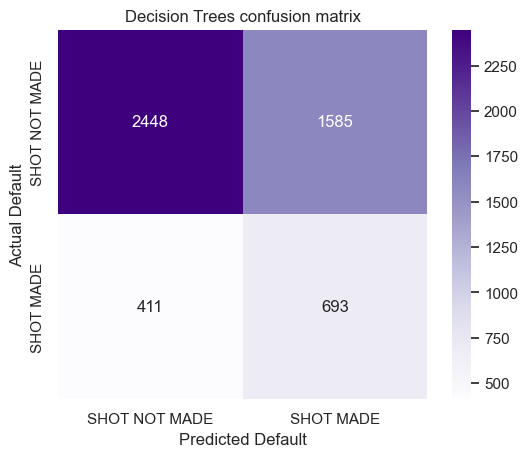

In [71]:
print(f"Training Accuracy: {rf.score(X_train_transformed, y_train)}")
print(f"Test Accuracy: {rf.score(X_valid_transformed, y_valid)}")
print(f"Test Accuracy: {rf.score(X_test_transformed, y_test)}")


probabilities = rf.predict_proba(X_valid_transformed)
loss = log_loss(y_valid, probabilities)
print(f"The log loss of the Random Forest Regressor model is: {loss:.4f}")


predictions1 = rf.predict(X_valid_transformed)
predictions = rf_untuned.predict(X_test_transformed)

trees_confusion= confusion_matrix(predictions1, y_valid)

# Visualize the results by using a heeatmap. 
sns.heatmap(
    trees_confusion, 
    cmap="Purples",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"]
).set(
    xlabel='Predicted Default',
    ylabel='Actual Default',
    title='Decision Trees confusion matrix')

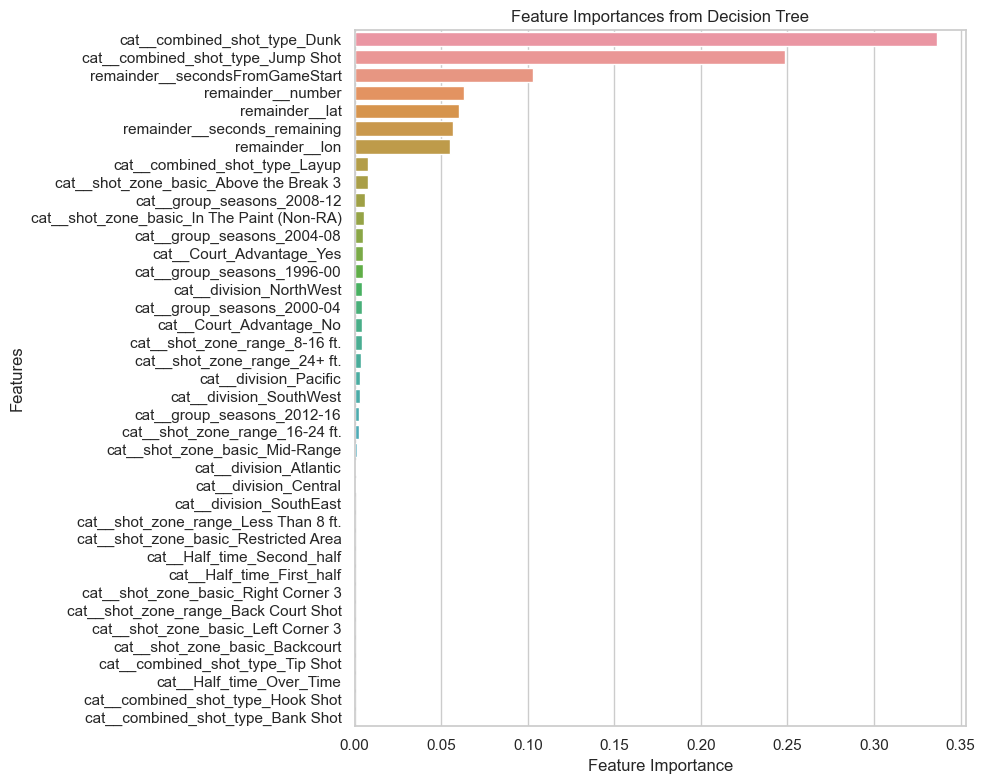

In [72]:
# Sort features by importance
sorted_idx = np.argsort(rf.feature_importances_)[::-1]
sorted_importances = rf.feature_importances_[sorted_idx]
sorted_features = np.array(preprocessor.get_feature_names_out())[sorted_idx]

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Decision Tree')
plt.tight_layout()
plt.show()

# Step 8: Gradient Boosting

In [73]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(C=0.1, penalty="l1", solver="saga")
dt = DecisionTreeClassifier(max_depth=2, min_samples_split=2)
knn = KNeighborsClassifier(n_neighbors=5)

model = VotingClassifier(estimators=[
    ('lr', lr), 
    ('dt', dt),
    ], 
    voting='hard'
)

model.fit(X_train_transformed, y_train)
model.score(X_train_transformed,y_train)

0.5547336318214262

In [74]:
'''from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
gb = GradientBoostingClassifier(random_state=2023)

params = {
    'n_estimators': np.arange(start=200, stop=1100, step=100),
    'learning_rate': [.001, .01, .1,],
    'max_features': [None],
    'subsample': [.8, .9, ],
    'max_depth': np.arange(start=3, stop=12, step=3),
    'min_samples_leaf': [2, 5, 10]    
}

grid = RandomizedSearchCV(
    gb, 
    params,
    n_iter=100,
    scoring="accuracy"
)

grid.fit(X_train_transformed, y_train)

grid.best_params_'''

'from sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\ngb = GradientBoostingClassifier(random_state=2023)\n\nparams = {\n    \'n_estimators\': np.arange(start=200, stop=1100, step=100),\n    \'learning_rate\': [.001, .01, .1,],\n    \'max_features\': [None],\n    \'subsample\': [.8, .9, ],\n    \'max_depth\': np.arange(start=3, stop=12, step=3),\n    \'min_samples_leaf\': [2, 5, 10]    \n}\n\ngrid = RandomizedSearchCV(\n    gb, \n    params,\n    n_iter=100,\n    scoring="accuracy"\n)\n\ngrid.fit(X_train_transformed, y_train)\n\ngrid.best_params_'

In [75]:



grid = GradientBoostingClassifier(
    random_state = 2023,
    n_estimators = 580,
    learning_rate = 0.03,
    max_features= 'sqrt',
    max_depth= 4,
    min_samples_leaf= 2,
    #max_features = 'sqrt'
)

grid.fit(X_train_transformed, y_train)

NameError: name 'GradientBoostingClassifier' is not defined

In [ ]:
grid.score(X_train_transformed,y_train)

In [ ]:
valid_predictions = grid.predict(X_valid_transformed)
test_predictions = grid.predict(X_test_transformed)

In [ ]:
print(accuracy_score(valid_predictions, y_valid))
accuracy_score(test_predictions, y_test)

In [ ]:
if hasattr(dt, "predict_proba"):
    probabilities_valid = grid.predict_proba(X_valid_transformed)
    loss_valid = log_loss(y_valid, probabilities_valid)
    print(f"Log Loss (Validation): {loss_valid:.4f}\n")
    
    
# Make prediction for validation and testing set.
valid_predictions = grid.predict(X_valid_transformed)
test_predictions = grid.predict(X_test_transformed)

# Calculate the Accuracy of the training set
print(f"Train Accuracy: {grid.score(X_train_transformed, y_train)}\n")


# Calculate some metrics for the Validation Set
print("------- Calculate Metrics for Validation set.--------")
print(f"Validation Accuracy: {grid.score(X_valid_std, y_valid)}")
print(f"The precision score for validation set is: {precision_score(y_valid,valid_predictions)}")
print(f"The recall score for validation set is: {recall_score(y_valid,valid_predictions)}")
print(f"The F1 score for validation set is: {f1_score(y_valid,valid_predictions)}\n")

probabilities_valid = grid.predict_proba(X_valid_transformed)
loss_valid = log_loss(y_valid, probabilities_valid)
print(f"Log Loss (Validation): {loss_valid:.4f}\n")
    
# Calculate some metrics for the testing set.
print("------- Calculate Metrics for Testing set.--------")
print(f"Validation Accuracy: {grid.score(X_test_std, y_test)}")
print(f"The precision score for validation set is: {precision_score(y_test,test_predictions)}")
print(f"The recall score for validation set is: {recall_score(y_test,test_predictions)}")
print(f"The F1 score for validation set is: {f1_score(y_test,test_predictions)}\n")

In [ ]:
'''from xgboost import XGBClassifier

params = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'colsample_bytree': 0.55,
    'min_child_weight': 9.0, 
    'subsample': 1.0, 
    'learning_rate': 0.03,
    'eta': 0.2, 
    'max_depth': 7, 
    'gamma': 0.75,
    'num_class': 2,
    'n_estimators': 580
}

# Initialize the model with the parameters
model = XGBClassifier(**params)

# Fit the model
model.fit(X_train_transformed, y_train)

# Evaluate the model
score = model.score(X_train_transformed, y_train)

print(score)
'''

In [ ]:
precision_score

# STEP 8: Artificial Neural Network.

In [76]:
import tensorflow as tf

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the model
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=512, activation='relu', input_shape=(X_train_std.shape[1],)))
ann.add(tf.keras.layers.Dropout(0.3))
ann.add(tf.keras.layers.Dense(units=256, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.3))
ann.add(tf.keras.layers.Dense(units=256, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.3))
ann.add(tf.keras.layers.Dense(units=128, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.3))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            loss='binary_crossentropy', 
            metrics=['accuracy'])

# Set up callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = ann.fit(X_train_std, y_train, 
                  batch_size=64, 
                  epochs=100, 
                  validation_data=(X_valid_std, y_valid), 
                  callbacks=[early_stopping, model_checkpoint])

# Predict probabilities on the validation set
y_pred_prob = ann.predict(X_valid_std)

# Calculate log loss
loss = log_loss(y_valid, y_pred_prob)
print("Log Loss:", loss)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Evaluate accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Epoch 1/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5432 - loss: 0.6884 - val_accuracy: 0.6155 - val_loss: 0.6562
Epoch 2/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5989 - loss: 0.6654 - val_accuracy: 0.6144 - val_loss: 0.6509
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6022 - loss: 0.6607 - val_accuracy: 0.6136 - val_loss: 0.6502
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6099 - loss: 0.6537 - val_accuracy: 0.6113 - val_loss: 0.6501
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6055 - loss: 0.6572 - val_accuracy: 0.6122 - val_loss: 0.6499
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6091 - loss: 0.6545 - val_accuracy: 0.6120 - val_loss: 0.6499
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6157 - loss: 0.6510 - val_accuracy: 0.6134 - val_loss: 0.6506
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6053 - loss: 0.6540 - val_accu

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Log Loss: 0.6501352312094698
Accuracy: 0.6185286103542235


[Text(0.5, 20.049999999999997, 'Predicted Default'),
 Text(74.45000000000006, 0.5, 'Actual Default'),
 Text(0.5, 1.0, 'Decision Trees confusion matrix')]

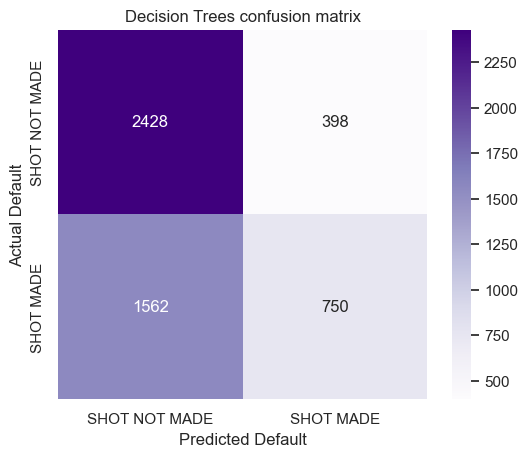

In [95]:
# Predict probabilities on the validation set
y_pred_prob = ann.predict(X_test_std)

# Calculate log loss
loss = log_loss(y_test, y_pred_prob)
print("Log Loss:", loss)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Visualize the results by using a heeatmap. 
sns.heatmap(
    conf_matrix, 
    cmap="Purples",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"]
).set(
    xlabel='Predicted Default',
    ylabel='Actual Default',
    title='Decision Trees confusion matrix')

[Text(0.5, 20.049999999999997, 'Predicted Default'),
 Text(74.45000000000006, 0.5, 'Actual Default'),
 Text(0.5, 1.0, 'Decision Trees confusion matrix')]

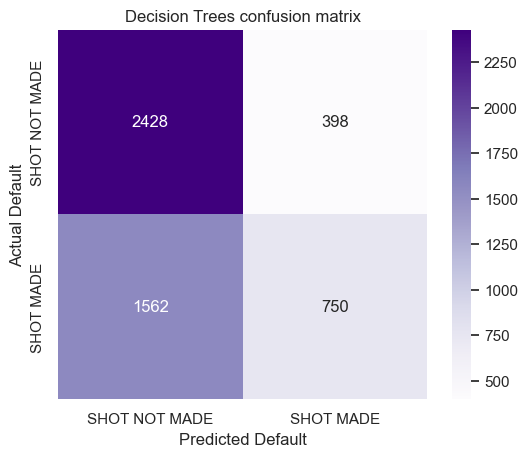

In [94]:
# Visualize the results by using a heeatmap. 
sns.heatmap(
    conf_matrix, 
    cmap="Purples",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["SHOT NOT MADE", "SHOT MADE"],        
    yticklabels=["SHOT NOT MADE", "SHOT MADE"]
).set(
    xlabel='Predicted Default',
    ylabel='Actual Default',
    title='Decision Trees confusion matrix')